In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/fix-SampleToMask/examples/paper-examples/6-cell_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 6. Cell Counting

Trains a U-Net to count the number of cells in the BBBC039 dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import skimage
import skimage.morphology
import scipy

import deeptrack as dt
from deeptrack.extras import datasets
datasets.load("CellCounting")

IMAGE_SIZE = 256

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


## 2. Defining the dataset

We begin by defining a fluorescence microscope.

In [3]:
optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: 0.9 + np.random.rand() * 0.2,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)


### 2.1 Generating cell-like scatterers.

Cells are represented as random ellipses with some elastic transformation applied to them. We use the dummy properties `area` amd `ratio` to constrain the possible ellipses.

In [4]:
ellipse = dt.Ellipsoid(
    area=lambda: (np.random.rand() * 3e-6 + 1e-6) ** 2,
    ratio=lambda: 1 + np.random.rand() * 0.5,
    radius=lambda area, ratio: (np.sqrt(area) * ratio, np.sqrt(area) / ratio, np.sqrt(area) * (0.2 + np.random.rand() * 0.2)),
    position_unit="pixel",
    intensity=lambda: 0.5 + np.random.rand(),
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    rotation=lambda: np.random.rand() * 2 * np.pi,
    voxel_size=optics.voxel_size
)

ellipses = ellipse ^ (lambda: np.random.randint(1, 20))

# Padding to ensure that the elastic transformation has space to grow into
padded_ellipses = ellipses >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)

# alpha and sigma chosen by observation.
cells = padded_ellipses >> dt.ElasticTransformation(alpha=100, sigma=10, keep_size=False)

Adding internal structure to the cells. We use poisson distributed noise and a 3d average smoothing filter.

In [5]:

noisy_cells = cells >> dt.Poisson(snr=lambda: 1.5 + np.random.rand() * 1.5)

kernel = np.ones((3, 3, 3)) / 27

smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel) * (image > 0)) 

# We apply the smoothening filter a random number of times to 
noisy_cells >>= smoothing ^ (lambda: np.random.randint(0, 3))

For each cell in the input, we calculate the centroid, and place a 1 at the nearest pixel.

In [6]:
def get_mask(image):
    projected_image = np.sum(image, axis=-1)
    mask = projected_image > 0.5
    X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    area = np.sum(mask)
    x_center = np.sum(mask * Y) / area
    y_center = np.sum(mask * X) / area
    output = np.zeros_like(image)
    output[int(x_center), int(y_center)] = 1
    return output

synthetic_mask = cells >> dt.SampleToMasks(
    lambda: get_mask, 
    number_of_masks=1,
    output_region=optics.output_region, 
    merge_method="add"
)

The synthetic mask created this way is convolved with a gaussian filter. This way we represent each cell by a gaussian curve.

In [7]:
from skimage.filters import gaussian 

NORM_FACTOR = 1000

def gaussian_filter(width):
    def apply_guassian_filter(image):
        image = np.pad(image, [(1, 1), (1, 1), (0, 0)])
        image = gaussian(image, width, truncate=2.5) * NORM_FACTOR
        image = image[1:-1, 1:-1]
        return image
    return apply_guassian_filter

make_gaussian = dt.Lambda(function=gaussian_filter, width=12)

blurred_synthetic_mask = synthetic_mask >> make_gaussian

Image the cells through an optical device. We also add some noise to the image, followed by normalizing it and augmenting it and the blurred masks together.

In [8]:

imaged_cells = optics(noisy_cells)

image_noise = dt.Gaussian(mu=lambda: np.random.rand() + 0.5, sigma=0.04)
saturation = dt.Clip(0, lambda: 17)
normalization = dt.NormalizeMinMax(min=lambda: np.random.rand() * 0.3, max=lambda min: min + 0.2 + np.random.rand() * (1 - min - 0.2))

noisy_image = imaged_cells >> image_noise >> saturation >> normalization

synthetic_dataset = dt.Reuse(noisy_image & blurred_synthetic_mask, 8) >> dt.FlipUD() >> dt.FlipLR() >> dt.FlipDiagonal()

### 2.3 Defining the validation set

We grab the filenames of the data in the different sets. Training and validation are merged into validation, since we don't use the training set.

In [9]:
DATASET_PATH = "./datasets/CellCounting/"
TRAINING_PATH = os.path.join(DATASET_PATH, "metadata", "validation.txt")
VALIDATION_PATH = os.path.join(DATASET_PATH, "metadata", "training.txt")
TEST_PATH = os.path.join(DATASET_PATH, "metadata", "test.txt")

training_filenames = open(TRAINING_PATH, "r").read().split("\n")[:-1]
validation_filenames = open(VALIDATION_PATH, "r").read().split("\n")[:-1]
test_filenames = open(TEST_PATH, "r").read().split("\n")[:-1]

validation_paths = [filename[:-4] for filename in training_filenames + validation_filenames]
test_paths = [filename[:-4] for filename in test_filenames]

We define image loading features for the validation images and masks. Here, `filename` is a dummy property. Note that `validation_image` has the filename set to `validation_filename_iterator`, while `validation_mask` has filename pointing to `validation_image.filename`. This way we ensure that they are grabbing a correct pair of images.

In [10]:
validation_filename_iterator = itertools.cycle(validation_paths)

validation_image = dt.LoadImage(
    filename=validation_filename_iterator,
    path=lambda filename: os.path.join(DATASET_PATH, "images", filename) + ".tif"
)

validation_mask = dt.LoadImage(
    filename=validation_image.filename,
    path=lambda filename: os.path.join(DATASET_PATH, "masks", filename) + ".png"
)

We do the same for the test set.

In [11]:
test_filename_iterator = itertools.cycle(test_paths)

test_image = dt.LoadImage(
    filename=test_filename_iterator,
    path=lambda filename: os.path.join(DATASET_PATH, "images", filename) + ".tif"
)

test_mask = dt.LoadImage(
    filename=test_image.filename,
    path=lambda filename: os.path.join(DATASET_PATH, "masks", filename) + ".png"
)

The masks are provided as color coded images. We define a feature that converts this to the masks used in training.

In [12]:
def decode_mask(validation_mask):
    integer_labels = skimage.morphology.label(validation_mask)[:, :, 0:1]
    props = skimage.measure.regionprops(integer_labels)

    output = np.zeros(integer_labels.shape)    
    for prop in props:
        centroid = prop["Centroid"]
        output[int(centroid[0]), int(centroid[1]), 0] = 1
    
    return output

png_to_mask = dt.Lambda(lambda: decode_mask) >> make_gaussian

In [13]:
normalization = dt.NormalizeMinMax()

blurred_validation_mask = validation_mask >> png_to_mask 
normalized_validation_image = validation_image >> normalization
validation_dataset = normalized_validation_image & blurred_validation_mask 

blurred_test_mask = test_mask >> png_to_mask
normalized_test_image = test_image >> normalization
test_dataset = normalized_test_image & blurred_test_mask

We also make sure they're a multiple of 16, which is needed by the network architecture.

In [14]:
cropper = dt.CropToMultiplesOf(16)

validation_dataset >>= cropper
test_dataset >>= cropper

We define a feature for loading the mask.

In [15]:
# Load labels from storage
def get_image(image):
    I = image[0]
    if I.ndim == 2:
        I = np.expand_dims(I, axis=-1)
    return I

def get_label(image):
    I = image[1]
    return I

### 2.4 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images and print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`.

C:\Users\GU\AppData\Local\Temp\ipykernel_8380\471691129.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel) * (image > 0))
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.351795481363343 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:276: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


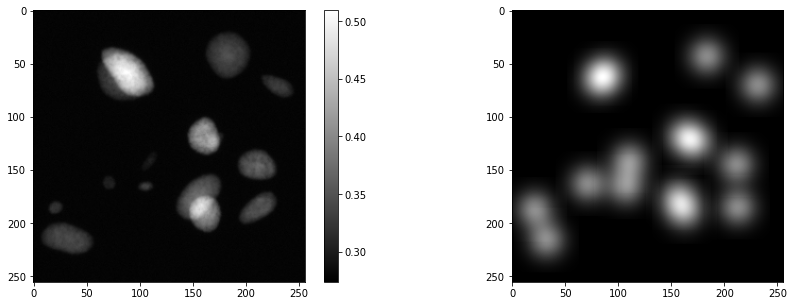

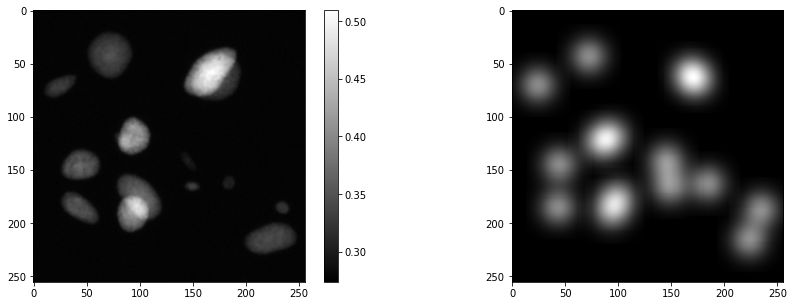

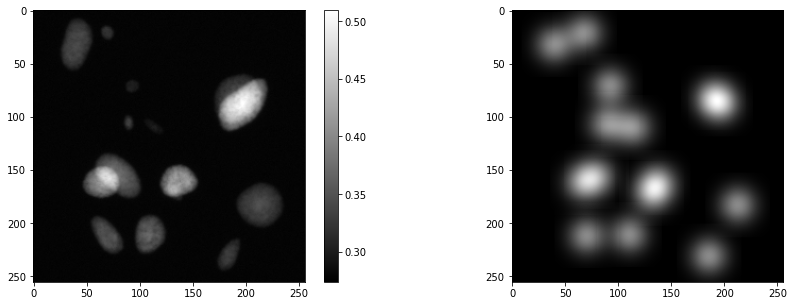

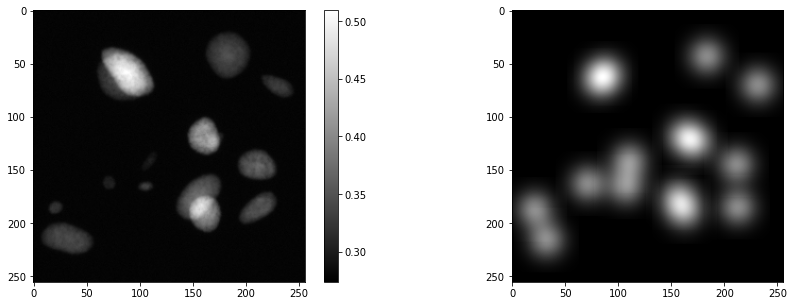

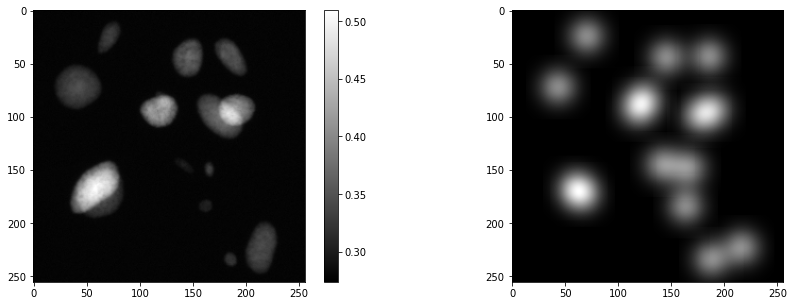

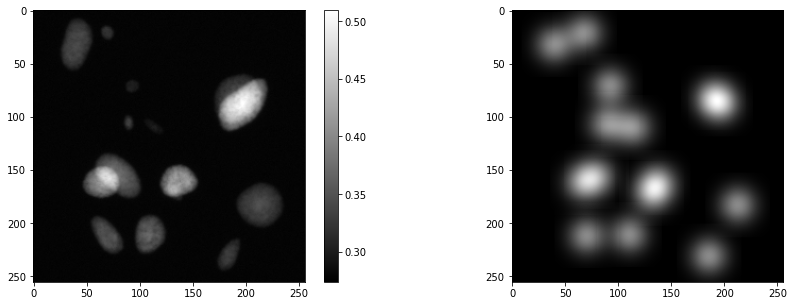

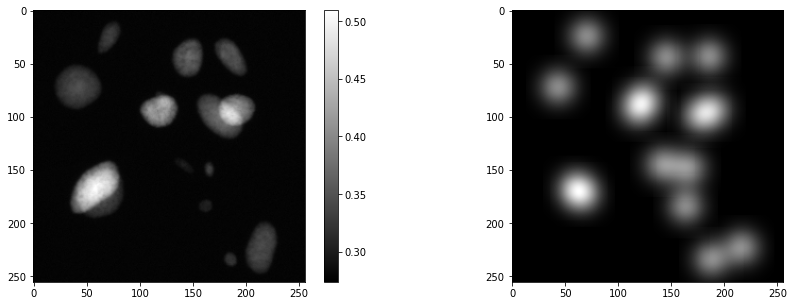

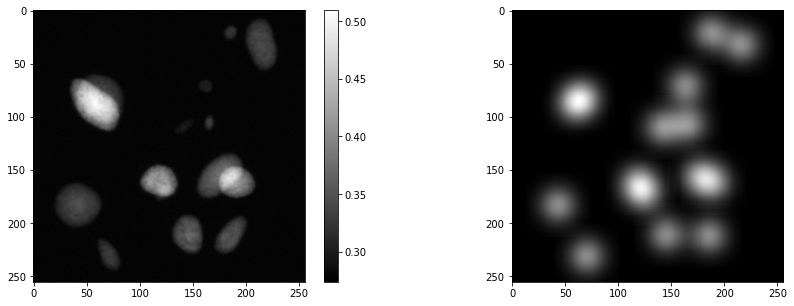

In [16]:
training_data = []
training_masks = []
for i in range(8):
        
    image, mask = synthetic_dataset.update().resolve()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.show()

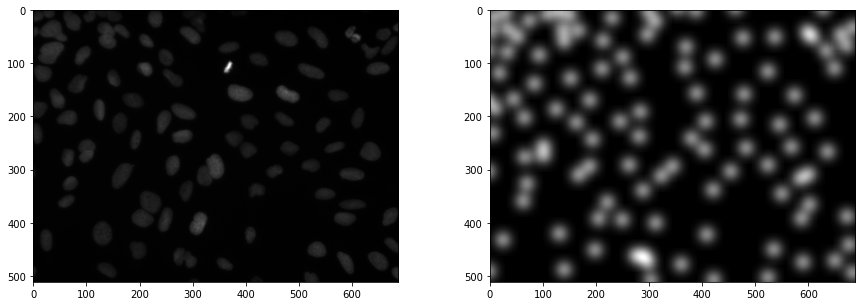

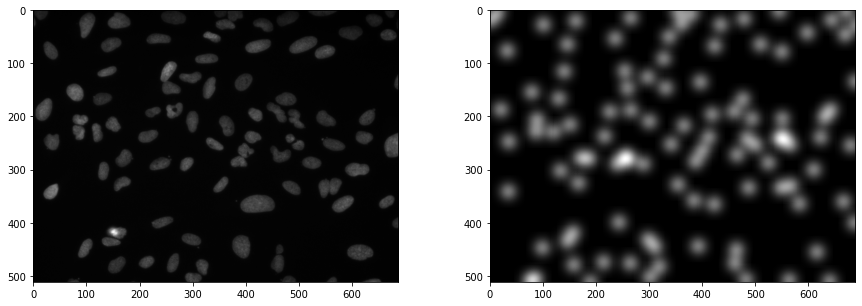

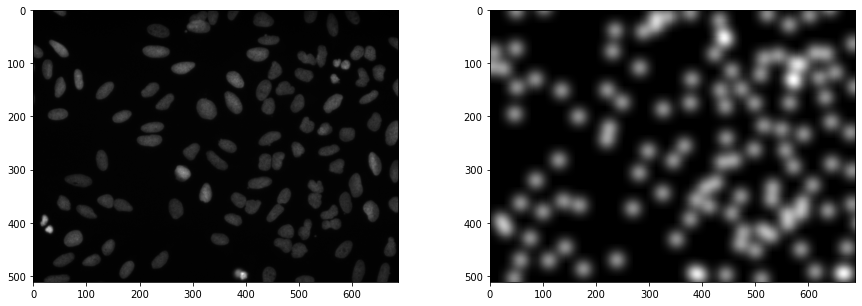

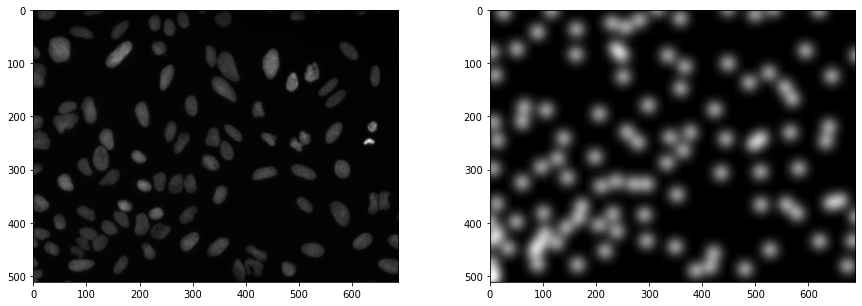

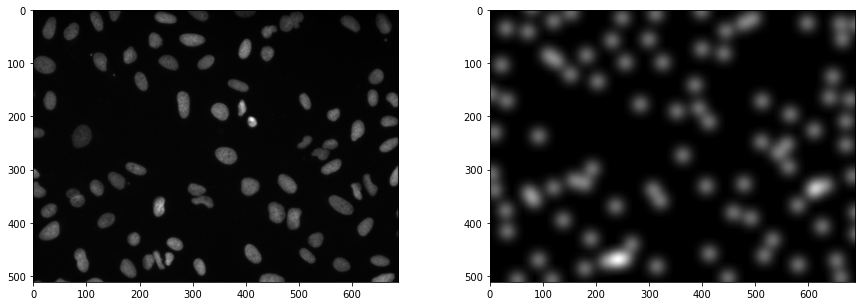

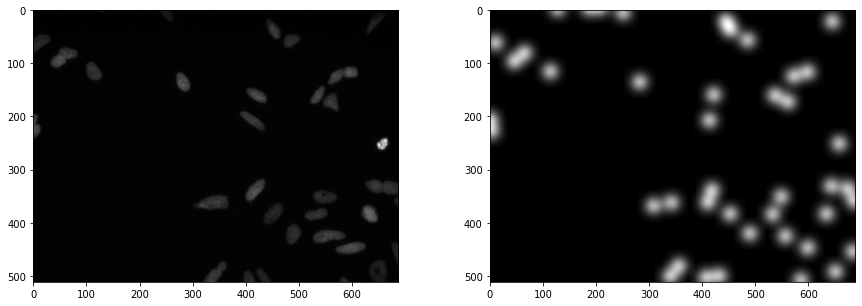

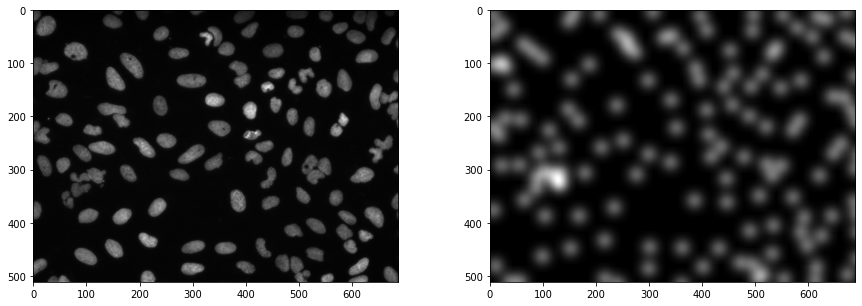

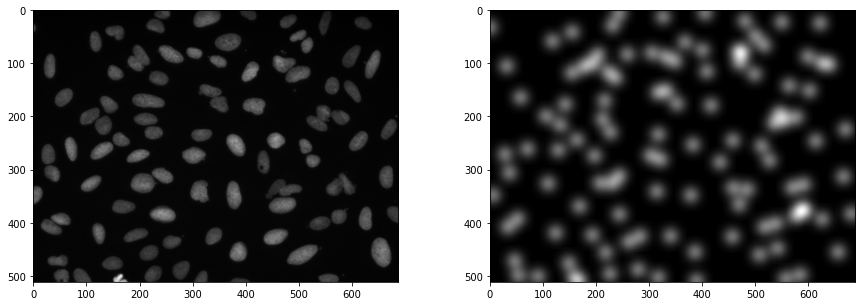

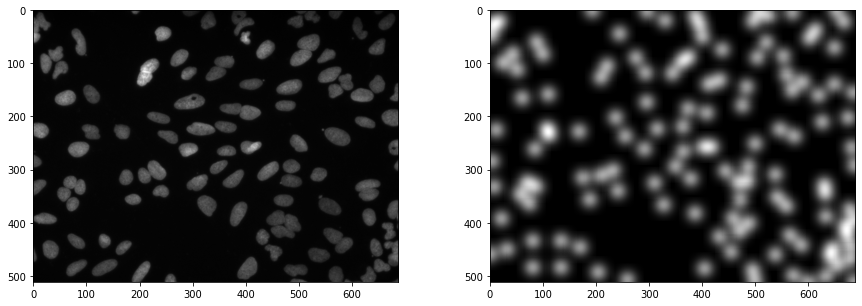

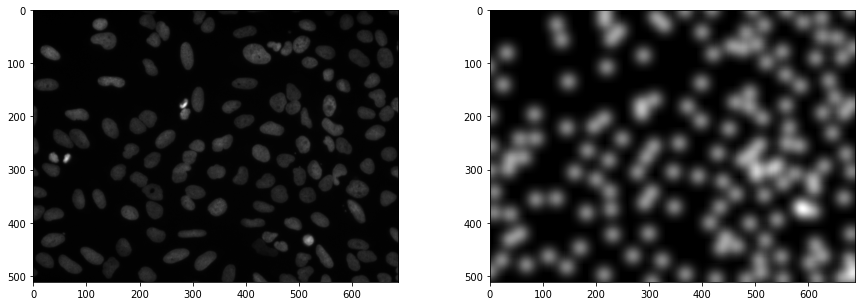

In [17]:
for _ in range(10):
    validation_dataset.update()
    image, mask = validation_dataset.resolve()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.subplot(122)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.show()

## 3. Defining the network

The network used is a U-Net Here we define the network architecture, loss function and the optimizer.

In [18]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.losses as losses
eps = 1e-6

loss_weights = [4, 1]

# Standard MAE
def mae(T, P):
    return K.mean(K.abs(T - P)) 

# Difference in mean
def count_error(T, P):
    return K.mean(K.abs(K.mean(T - P, axis=(1, 2)))) 

# Weighted sum of loss
def total_loss(T, P):
    return mae(T, P) * loss_weights[0] + count_error(T, P) * loss_weights[1]


model = dt.models.UNet(
    input_shape=(None, None, 1),
    number_of_outputs=1,
    steps_per_pooling=2,
    output_activation="relu",
    loss=total_loss,
    optimizer=tf.keras.optimizers.Adam(lr=0.0002, amsgrad=True, beta_1=0.5),
    metrics=[mae, count_error],
)
    
model.summary()

C:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 activation (Activation)        (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

## 4. Training the network

In [19]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    from tensorflow.keras.callbacks import EarlyStopping


    generator = dt.generators.ContinuousGenerator(
        synthetic_dataset, 
        get_label, 
        get_image, 
        batch_size=16, 
        min_data_size=1000, 
        max_data_size=1001,
    )

    validation_set = [validation_dataset.update().resolve() for _ in range(len(validation_paths))]
    validation_data = [get_image(v_tuple) for v_tuple in validation_set]
    validation_labels = [get_label(v_tuple) for v_tuple in validation_set]

    with generator:
        h = model.fit(
            generator,
            steps_per_epoch=8,
            epochs=500,
            workers=0,
            validation_data=(
                np.array(validation_data),
                np.array(validation_labels)
            ), 
            callbacks = [
                EarlyStopping("val_count_error", patience=50, restore_best_weights=True)
            ] 
        )
else:
    path = datasets.load_model("CellCounting")
    model.load_weights(path)

C:\Users\GU\AppData\Local\Temp\ipykernel_8380\471691129.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel) * (image > 0))
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.826571906754168 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:276: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.47123038299124 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.767655842923094 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.975206105054088 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.739423225592184 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.15263862504077 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.323407248243862 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.197663146521158 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.409947949881401 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.089186006933367 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.582831047310876 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.061481943586951 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.680554832695552 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.694104186616592 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.542011936433024 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.119826372953934 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.800393963303334 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.97171667162622 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.482133070379225 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.607943801414958 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.322971136751018 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.084429856327247 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.130621120861996 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.923943305099966 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.631367696102409 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.123400070134714 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.94052832173486 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.027643192365488 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.92575325042036 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.868624410435565 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.678138322589666 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.29621787837937 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.214387965073403 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.542173131528791 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.691344237876196 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.139556055528878 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.496219833307553 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.759004105136547 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.227529170470268 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.295058873826154 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.290594008434397 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.507479762809812 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.288641478685676 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.535624160142318 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.973948785295866 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.726499956336838 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.10217344885109 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.37365806844716 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.291712079364265 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.579177893062294 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.057725780213513 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.344520508404024 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.08649056752412 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.450114083517434 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.363286382339272 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.173589049161825 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.36968285931064 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.165332084461971 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.476276796739732 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.884247809606881 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.858723015735745 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.707690337727819 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.35694702866863 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.557378686431488 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.269795509606537 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.615620101299228 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.763544564863462 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.100350719319046 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.896586041308776 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.284773216125224 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.30847352574983 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.103748142476697 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.835764730585813 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.972555309346479 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.629881268630708 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.929961992505202 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.44326745244333 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.897331691414855 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.823602363907199 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.945871607470476 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.918322731979046 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.424357961352433 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.34311219525558 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.0176076565849 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.014768669131211 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.736970856186586 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.229099746979259 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.590853416790953 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.997488427585889 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.327653505990856 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.561007677655567 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.196975592524346 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.143229380645241 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.710238986662494 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.078492797698473 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.366041302646044 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.01653930161451 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.709940779170292 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.490757004077725 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.14538632322241 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.690155637821318 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.060942876016323 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.460367206171153 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.53664692073373 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.243918423565823 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.415861546045377 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.183013333091733 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.455432557376433 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.1456234686366 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.64940723856496 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.602542812607235 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.784449047500576 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.703256406080392 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.970030790430993 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.657144089789522 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.260263461210144 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.3430443013437 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.194240975729365 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.893368159099746 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.09600690480649 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.692481346845863 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.074252300125831 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.826629226291512 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.465864684945895 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.26596487852468 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.314582434579673 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


Generating 1000 / 1000 samples before starting training
Epoch 1/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.191420607166943 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.325929911126345 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.17806958680438 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

6/8 [=====================>........] - ETA: 0s - loss: 0.7513 - mae: 0.1522 - count_error: 0.1426

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.771113387421586 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.7489 - mae: 0.1523 - count_error: 0.1397

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.537010901049413 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.104578309153347 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.057440174582904 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

8/8 [==============================] - 13s 627ms/step - loss: 0.7489 - mae: 0.1523 - count_error: 0.1397 - val_loss: 1.5423 - val_mae: 0.3064 - val_count_error: 0.3058
Epoch 2/500
6/8 [=====================>........] - ETA: 0s - loss: 0.7256 - mae: 0.1512 - count_error: 0.1207

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.954969446798325 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.7154 - mae: 0.1490 - count_error: 0.1194

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.58930016587723 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.7154 - mae: 0.1490 - count_error: 0.1194 - val_loss: 1.5529 - val_mae: 0.3084 - val_count_error: 0.3083
Epoch 3/500
8/8 [==============================] - ETA: 0s - loss: 0.7070 - mae: 0.1459 - count_error: 0.1233

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.518244880100132 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.7070 - mae: 0.1459 - count_error: 0.1233 - val_loss: 1.5377 - val_mae: 0.3052 - val_count_error: 0.3051
Epoch 4/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.759354814364125 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.7089 - mae: 0.1478 - count_error: 0.1179

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.060693726182693 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.67031566244267 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.7089 - mae: 0.1478 - count_error: 0.1179 - val_loss: 1.5441 - val_mae: 0.3063 - val_count_error: 0.3059
Epoch 5/500
8/8 [==============================] - ETA: 0s - loss: 0.6053 - mae: 0.1233 - count_error: 0.1123

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.79405417410291 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.8031313127372 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 154ms/step - loss: 0.6053 - mae: 0.1233 - count_error: 0.1123 - val_loss: 1.5409 - val_mae: 0.3056 - val_count_error: 0.3052
Epoch 6/500
6/8 [=====================>........] - ETA: 0s - loss: 0.6635 - mae: 0.1352 - count_error: 0.1225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.172098044930078 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.6366 - mae: 0.1299 - count_error: 0.1168

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.693772789795585 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.6366 - mae: 0.1299 - count_error: 0.1168 - val_loss: 1.4531 - val_mae: 0.2881 - val_count_error: 0.2869
Epoch 7/500
7/8 [=========================>....] - ETA: 0s - loss: 0.5219 - mae: 0.1092 - count_error: 0.0851

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.542326418769171 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.5324 - mae: 0.1108 - count_error: 0.0893

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.566172589019846 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.5324 - mae: 0.1108 - count_error: 0.0893 - val_loss: 1.5386 - val_mae: 0.3056 - val_count_error: 0.3053
Epoch 8/500
3/8 [==========>...................] - ETA: 0s - loss: 0.6976 - mae: 0.1399 - count_error: 0.1379

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.930974761406592 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.6502 - mae: 0.1325 - count_error: 0.1203

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.32923518531409 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.712228119369659 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.6502 - mae: 0.1325 - count_error: 0.1203 - val_loss: 1.4461 - val_mae: 0.2871 - val_count_error: 0.2839
Epoch 9/500
8/8 [==============================] - ETA: 0s - loss: 0.5371 - mae: 0.1126 - count_error: 0.0865

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.367647355222216 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.5371 - mae: 0.1126 - count_error: 0.0865 - val_loss: 1.2634 - val_mae: 0.2518 - val_count_error: 0.2410


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.063723885135264 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


Epoch 10/500
7/8 [=========================>....] - ETA: 0s - loss: 0.4595 - mae: 0.0982 - count_error: 0.0666

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.071959035031337 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.4654 - mae: 0.0993 - count_error: 0.0681

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.619807888677881 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.4654 - mae: 0.0993 - count_error: 0.0681 - val_loss: 1.0121 - val_mae: 0.2078 - val_count_error: 0.1662
Epoch 11/500
2/8 [======>.......................] - ETA: 0s - loss: 0.3810 - mae: 0.0832 - count_error: 0.0481

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.298842813248335 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


6/8 [=====================>........] - ETA: 0s - loss: 0.4602 - mae: 0.0987 - count_error: 0.0652

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.532960875606282 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.4687 - mae: 0.1003 - count_error: 0.0676

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.691256209683925 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.588252806414964 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 175ms/step - loss: 0.4687 - mae: 0.1003 - count_error: 0.0676 - val_loss: 1.1767 - val_mae: 0.2363 - val_count_error: 0.2144
Epoch 12/500
5/8 [=================>............] - ETA: 0s - loss: 0.4501 - mae: 0.0968 - count_error: 0.0630

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.077922116849905 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.4556 - mae: 0.0981 - count_error: 0.0633

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.17901576212108 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.4556 - mae: 0.0981 - count_error: 0.0633 - val_loss: 0.9933 - val_mae: 0.2042 - val_count_error: 0.1630
Epoch 13/500
7/8 [=========================>....] - ETA: 0s - loss: 0.3929 - mae: 0.0854 - count_error: 0.0511

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.488972533696256 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3979 - mae: 0.0861 - count_error: 0.0534

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.41364265189619 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 154ms/step - loss: 0.3979 - mae: 0.0861 - count_error: 0.0534 - val_loss: 0.9895 - val_mae: 0.1997 - val_count_error: 0.1765
Epoch 14/500
6/8 [=====================>........] - ETA: 0s - loss: 0.5542 - mae: 0.1166 - count_error: 0.0877

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.80164688425949 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.5899 - mae: 0.1224 - count_error: 0.1004

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.665595298866396 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 158ms/step - loss: 0.5899 - mae: 0.1224 - count_error: 0.1004 - val_loss: 1.4718 - val_mae: 0.2925 - val_count_error: 0.2912
Epoch 15/500
6/8 [=====================>........] - ETA: 0s - loss: 0.5734 - mae: 0.1191 - count_error: 0.0969

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.946579092816599 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.5339 - mae: 0.1118 - count_error: 0.0867

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.390503349795306 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.5339 - mae: 0.1118 - count_error: 0.0867 - val_loss: 1.0996 - val_mae: 0.2218 - val_count_error: 0.1956
Epoch 16/500
3/8 [==========>...................] - ETA: 0s - loss: 0.4468 - mae: 0.0970 - count_error: 0.0586

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.236269547530746 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.4525 - mae: 0.0965 - count_error: 0.0667

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.23868721672525 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.4525 - mae: 0.0965 - count_error: 0.0667 - val_loss: 1.0587 - val_mae: 0.2128 - val_count_error: 0.1932
Epoch 17/500
1/8 [==>...........................] - ETA: 0s - loss: 0.4664 - mae: 0.0997 - count_error: 0.0675

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.040330574490012 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3876 - mae: 0.0846 - count_error: 0.0494

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.14396414342009 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.3876 - mae: 0.0846 - count_error: 0.0494 - val_loss: 0.9706 - val_mae: 0.1957 - val_count_error: 0.1744
Epoch 18/500
2/8 [======>.......................] - ETA: 0s - loss: 0.2912 - mae: 0.0642 - count_error: 0.0342

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.22471992716345 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3615 - mae: 0.0791 - count_error: 0.0451

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.47671153712971 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.3615 - mae: 0.0791 - count_error: 0.0451 - val_loss: 0.8146 - val_mae: 0.1707 - val_count_error: 0.1181
Epoch 19/500
1/8 [==>...........................] - ETA: 0s - loss: 0.3070 - mae: 0.0697 - count_error: 0.0283

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.177336994438285 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3546 - mae: 0.0781 - count_error: 0.0422

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.481612630942234 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.758800807655934 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.3546 - mae: 0.0781 - count_error: 0.0422 - val_loss: 0.7332 - val_mae: 0.1572 - val_count_error: 0.0921
Epoch 20/500
8/8 [==============================] - ETA: 0s - loss: 0.3560 - mae: 0.0777 - count_error: 0.0453

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.032008123496867 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.3560 - mae: 0.0777 - count_error: 0.0453 - val_loss: 1.0563 - val_mae: 0.2105 - val_count_error: 0.2006
Epoch 21/500
1/8 [==>...........................] - ETA: 0s - loss: 0.4319 - mae: 0.0902 - count_error: 0.0711

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.823798690741445 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3490 - mae: 0.0761 - count_error: 0.0445

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.344546216031187 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.3490 - mae: 0.0761 - count_error: 0.0445 - val_loss: 0.7512 - val_mae: 0.1616 - val_count_error: 0.0912
Epoch 22/500
2/8 [======>.......................] - ETA: 0s - loss: 0.3517 - mae: 0.0799 - count_error: 0.0320

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.848662802260261 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3656 - mae: 0.0787 - count_error: 0.0508

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.465250204106901 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.894709354594825 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.3656 - mae: 0.0787 - count_error: 0.0508 - val_loss: 0.7295 - val_mae: 0.1601 - val_count_error: 0.0763
Epoch 23/500
8/8 [==============================] - ETA: 0s - loss: 0.3158 - mae: 0.0704 - count_error: 0.0344

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.813293084126567 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.543815882065996 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.3158 - mae: 0.0704 - count_error: 0.0344 - val_loss: 0.7147 - val_mae: 0.1512 - val_count_error: 0.0986
Epoch 24/500
7/8 [=========================>....] - ETA: 0s - loss: 0.2974 - mae: 0.0664 - count_error: 0.0318

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.991656835309275 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2956 - mae: 0.0663 - count_error: 0.0303

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.018077594752967 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 153ms/step - loss: 0.2956 - mae: 0.0663 - count_error: 0.0303 - val_loss: 0.7051 - val_mae: 0.1480 - val_count_error: 0.1025
Epoch 25/500
6/8 [=====================>........] - ETA: 0s - loss: 0.2935 - mae: 0.0653 - count_error: 0.0325

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.683888508857896 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2891 - mae: 0.0645 - count_error: 0.0312

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.107564212150415 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.2891 - mae: 0.0645 - count_error: 0.0312 - val_loss: 0.7309 - val_mae: 0.1664 - val_count_error: 0.0565
Epoch 26/500
8/8 [==============================] - ETA: 0s - loss: 0.3269 - mae: 0.0721 - count_error: 0.0387

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.999244992878623 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.3269 - mae: 0.0721 - count_error: 0.0387 - val_loss: 0.6536 - val_mae: 0.1422 - val_count_error: 0.0747
Epoch 27/500
1/8 [==>...........................] - ETA: 0s - loss: 0.3009 - mae: 0.0671 - count_error: 0.0323

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.47143505498581 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3111 - mae: 0.0682 - count_error: 0.0382

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.646101818749639 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.704890306583994 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 168ms/step - loss: 0.3111 - mae: 0.0682 - count_error: 0.0382 - val_loss: 0.7045 - val_mae: 0.1589 - val_count_error: 0.0608
Epoch 28/500
5/8 [=================>............] - ETA: 0s - loss: 0.2761 - mae: 0.0618 - count_error: 0.0289

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.743984526431202 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2767 - mae: 0.0625 - count_error: 0.0268

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.518098752739178 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.2767 - mae: 0.0625 - count_error: 0.0268 - val_loss: 0.6140 - val_mae: 0.1410 - val_count_error: 0.0418
Epoch 29/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2902 - mae: 0.0641 - count_error: 0.0340

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.07818629802777 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.3067 - mae: 0.0668 - count_error: 0.0396

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.617556002069115 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.3067 - mae: 0.0668 - count_error: 0.0396 - val_loss: 0.9090 - val_mae: 0.1814 - val_count_error: 0.1735
Epoch 30/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.144210602914725 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


7/8 [=========================>....] - ETA: 0s - loss: 0.2820 - mae: 0.0622 - count_error: 0.0333

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.349281659556429 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2753 - mae: 0.0609 - count_error: 0.0315

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.650396894497284 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 170ms/step - loss: 0.2753 - mae: 0.0609 - count_error: 0.0315 - val_loss: 0.6292 - val_mae: 0.1311 - val_count_error: 0.0970
Epoch 31/500
6/8 [=====================>........] - ETA: 0s - loss: 0.2726 - mae: 0.0617 - count_error: 0.0259

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.329889065277595 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2694 - mae: 0.0605 - count_error: 0.0273

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.764993436888897 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 155ms/step - loss: 0.2694 - mae: 0.0605 - count_error: 0.0273 - val_loss: 0.5545 - val_mae: 0.1261 - val_count_error: 0.0422
Epoch 32/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2645 - mae: 0.0597 - count_error: 0.0259

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.473507659063257 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2430 - mae: 0.0545 - count_error: 0.0248

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.691240862715812 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2430 - mae: 0.0545 - count_error: 0.0248 - val_loss: 0.8122 - val_mae: 0.1627 - val_count_error: 0.1530
Epoch 33/500
1/8 [==>...........................] - ETA: 0s - loss: 0.4314 - mae: 0.0883 - count_error: 0.0781

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.178690178175632 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2848 - mae: 0.0621 - count_error: 0.0364

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.097441161988847 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.542377953469764 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.2848 - mae: 0.0621 - count_error: 0.0364 - val_loss: 0.5390 - val_mae: 0.1174 - val_count_error: 0.0618
Epoch 34/500
8/8 [==============================] - ETA: 0s - loss: 0.2983 - mae: 0.0653 - count_error: 0.0373

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.22204878554728 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.401754012834658 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.2983 - mae: 0.0653 - count_error: 0.0373 - val_loss: 0.5516 - val_mae: 0.1222 - val_count_error: 0.0546
Epoch 35/500
7/8 [=========================>....] - ETA: 0s - loss: 0.3026 - mae: 0.0665 - count_error: 0.0367

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.398694098212818 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2896 - mae: 0.0637 - count_error: 0.0349 - val_loss: 0.6923 - val_mae: 0.1400 - val_count_error: 0.1237


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.582870560807878 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


Epoch 36/500
8/8 [==============================] - ETA: 0s - loss: 0.2601 - mae: 0.0584 - count_error: 0.0265

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.436976312634636 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.002181539898082 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.2601 - mae: 0.0584 - count_error: 0.0265 - val_loss: 0.5488 - val_mae: 0.1268 - val_count_error: 0.0354
Epoch 37/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2735 - mae: 0.0619 - count_error: 0.0260

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.994193796688977 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2672 - mae: 0.0601 - count_error: 0.0266

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.944390714086676 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.2672 - mae: 0.0601 - count_error: 0.0266 - val_loss: 0.5131 - val_mae: 0.1107 - val_count_error: 0.0645
Epoch 38/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2281 - mae: 0.0506 - count_error: 0.0256

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.699982691383306 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2325 - mae: 0.0517 - count_error: 0.0255

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.26487996171845 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.2325 - mae: 0.0517 - count_error: 0.0255 - val_loss: 0.5026 - val_mae: 0.1150 - val_count_error: 0.0366
Epoch 39/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2564 - mae: 0.0583 - count_error: 0.0234

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.244685903311538 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2344 - mae: 0.0532 - count_error: 0.0216

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.00997400141908 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 159ms/step - loss: 0.2344 - mae: 0.0532 - count_error: 0.0216 - val_loss: 0.5781 - val_mae: 0.1319 - val_count_error: 0.0459
Epoch 40/500
3/8 [==========>...................] - ETA: 0s - loss: 0.3059 - mae: 0.0671 - count_error: 0.0374

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.163814225404757 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2997 - mae: 0.0655 - count_error: 0.0379

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.193146624610137 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.243085971185074 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.2997 - mae: 0.0655 - count_error: 0.0379 - val_loss: 0.5541 - val_mae: 0.1154 - val_count_error: 0.0860
Epoch 41/500
8/8 [==============================] - ETA: 0s - loss: 0.2500 - mae: 0.0557 - count_error: 0.0272

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.682514626581527 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.707362878939307 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2500 - mae: 0.0557 - count_error: 0.0272 - val_loss: 0.4935 - val_mae: 0.1087 - val_count_error: 0.0525
Epoch 42/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2387 - mae: 0.0529 - count_error: 0.0272

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.89724196127412 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2464 - mae: 0.0543 - count_error: 0.0294

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.045806593227908 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.2464 - mae: 0.0543 - count_error: 0.0294 - val_loss: 0.5542 - val_mae: 0.1149 - val_count_error: 0.0883
Epoch 43/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2844 - mae: 0.0602 - count_error: 0.0436

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.09440408373757 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2255 - mae: 0.0505 - count_error: 0.0236

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.774684341587829 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.25176588585607 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2255 - mae: 0.0505 - count_error: 0.0236 - val_loss: 0.5250 - val_mae: 0.1095 - val_count_error: 0.0815
Epoch 44/500
7/8 [=========================>....] - ETA: 0s - loss: 0.2160 - mae: 0.0483 - count_error: 0.0229

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.141582661361728 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2116 - mae: 0.0473 - count_error: 0.0225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.22865193251868 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 154ms/step - loss: 0.2116 - mae: 0.0473 - count_error: 0.0225 - val_loss: 0.4596 - val_mae: 0.1037 - val_count_error: 0.0397
Epoch 45/500
5/8 [=================>............] - ETA: 0s - loss: 0.2176 - mae: 0.0483 - count_error: 0.0244

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.711122429678898 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2327 - mae: 0.0510 - count_error: 0.0286

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.74341434624484 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.2327 - mae: 0.0510 - count_error: 0.0286 - val_loss: 0.4576 - val_mae: 0.1065 - val_count_error: 0.0268
Epoch 46/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2174 - mae: 0.0490 - count_error: 0.0215

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.198457150906894 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2294 - mae: 0.0508 - count_error: 0.0262

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.95813948059604 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.2294 - mae: 0.0508 - count_error: 0.0262 - val_loss: 0.4460 - val_mae: 0.1017 - val_count_error: 0.0347
Epoch 47/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2317 - mae: 0.0539 - count_error: 0.0163

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.134608182918367 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2163 - mae: 0.0489 - count_error: 0.0207

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.883132483088568 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2163 - mae: 0.0489 - count_error: 0.0207 - val_loss: 0.5262 - val_mae: 0.1100 - val_count_error: 0.0814
Epoch 48/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2134 - mae: 0.0480 - count_error: 0.0212

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.53086805486367 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2482 - mae: 0.0550 - count_error: 0.0283

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.161145077849437 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.2482 - mae: 0.0550 - count_error: 0.0283 - val_loss: 0.4569 - val_mae: 0.1032 - val_count_error: 0.0395
Epoch 49/500
2/8 [======>.......................] - ETA: 0s - loss: 0.2535 - mae: 0.0581 - count_error: 0.0210

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.95730347755031 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2617 - mae: 0.0581 - count_error: 0.0292

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.607738929092147 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.80994541182283 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.2617 - mae: 0.0581 - count_error: 0.0292 - val_loss: 0.4543 - val_mae: 0.1030 - val_count_error: 0.0377
Epoch 50/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1961 - mae: 0.0430 - count_error: 0.0240

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.25282586363034 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2120 - mae: 0.0468 - count_error: 0.0248

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.876239006195842 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.2120 - mae: 0.0468 - count_error: 0.0248 - val_loss: 0.4640 - val_mae: 0.1049 - val_count_error: 0.0387
Epoch 51/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2177 - mae: 0.0492 - count_error: 0.0208

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.890477766597325 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2083 - mae: 0.0471 - count_error: 0.0198

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.574248825293097 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.2083 - mae: 0.0471 - count_error: 0.0198 - val_loss: 0.5296 - val_mae: 0.1210 - val_count_error: 0.0418
Epoch 52/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2110 - mae: 0.0469 - count_error: 0.0233

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.12597311242121 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2105 - mae: 0.0468 - count_error: 0.0234

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.44351221150606 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.2105 - mae: 0.0468 - count_error: 0.0234 - val_loss: 0.4237 - val_mae: 0.0971 - val_count_error: 0.0311
Epoch 53/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1750 - mae: 0.0397 - count_error: 0.0163

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.922028908853388 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1739 - mae: 0.0392 - count_error: 0.0169

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.598366881315052 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 168ms/step - loss: 0.1739 - mae: 0.0392 - count_error: 0.0169 - val_loss: 0.5445 - val_mae: 0.1239 - val_count_error: 0.0447
Epoch 54/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.027147765421569 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2259 - mae: 0.0502 - count_error: 0.0253

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.872538851786288 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.2259 - mae: 0.0502 - count_error: 0.0253 - val_loss: 0.5618 - val_mae: 0.1297 - val_count_error: 0.0392
Epoch 55/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.13396036918871 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2230 - mae: 0.0500 - count_error: 0.0229

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.175779089347387 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.2230 - mae: 0.0500 - count_error: 0.0229 - val_loss: 0.5101 - val_mae: 0.1173 - val_count_error: 0.0341
Epoch 56/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2164 - mae: 0.0486 - count_error: 0.0219

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.195625397475439 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2311 - mae: 0.0515 - count_error: 0.0251

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.919722767763899 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.2311 - mae: 0.0515 - count_error: 0.0251 - val_loss: 0.4980 - val_mae: 0.1051 - val_count_error: 0.0714
Epoch 57/500
5/8 [=================>............] - ETA: 0s - loss: 0.2095 - mae: 0.0464 - count_error: 0.0241

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.021685284815053 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1934 - mae: 0.0432 - count_error: 0.0206

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.312128853937761 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1934 - mae: 0.0432 - count_error: 0.0206 - val_loss: 0.4636 - val_mae: 0.1080 - val_count_error: 0.0269
Epoch 58/500
8/8 [==============================] - ETA: 0s - loss: 0.1881 - mae: 0.0419 - count_error: 0.0206

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.517051288195441 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.871041140614746 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.1881 - mae: 0.0419 - count_error: 0.0206 - val_loss: 0.5485 - val_mae: 0.1236 - val_count_error: 0.0487
Epoch 59/500
7/8 [=========================>....] - ETA: 0s - loss: 0.2092 - mae: 0.0467 - count_error: 0.0225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.844998852314164 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2096 - mae: 0.0470 - count_error: 0.0216

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.94286176578496 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.2096 - mae: 0.0470 - count_error: 0.0216 - val_loss: 0.4268 - val_mae: 0.0993 - val_count_error: 0.0250
Epoch 60/500
5/8 [=================>............] - ETA: 0s - loss: 0.2333 - mae: 0.0520 - count_error: 0.0252

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.028310622294239 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2307 - mae: 0.0516 - count_error: 0.0243

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.878685343352007 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 170ms/step - loss: 0.2307 - mae: 0.0516 - count_error: 0.0243 - val_loss: 0.5524 - val_mae: 0.1242 - val_count_error: 0.0495
Epoch 61/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2200 - mae: 0.0504 - count_error: 0.0186

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.52752574075472 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1905 - mae: 0.0432 - count_error: 0.0178

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.078047011846813 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.337234372291539 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1905 - mae: 0.0432 - count_error: 0.0178 - val_loss: 0.4412 - val_mae: 0.0966 - val_count_error: 0.0504
Epoch 62/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1851 - mae: 0.0413 - count_error: 0.0199

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.95756391047642 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1919 - mae: 0.0431 - count_error: 0.0193

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.855486045982696 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1919 - mae: 0.0431 - count_error: 0.0193 - val_loss: 0.4397 - val_mae: 0.0950 - val_count_error: 0.0548
Epoch 63/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1857 - mae: 0.0413 - count_error: 0.0204

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.55816348556645 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2273 - mae: 0.0495 - count_error: 0.0292

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.9780278155284 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.125050735073232 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.2273 - mae: 0.0495 - count_error: 0.0292 - val_loss: 0.4364 - val_mae: 0.0961 - val_count_error: 0.0475
Epoch 64/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1913 - mae: 0.0427 - count_error: 0.0204

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.13046081286215 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1927 - mae: 0.0432 - count_error: 0.0200

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.591967480361097 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1927 - mae: 0.0432 - count_error: 0.0200 - val_loss: 0.4286 - val_mae: 0.0927 - val_count_error: 0.0535
Epoch 65/500
8/8 [==============================] - ETA: 0s - loss: 0.1907 - mae: 0.0425 - count_error: 0.0207

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.438953515892969 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.10901674565175 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1907 - mae: 0.0425 - count_error: 0.0207 - val_loss: 0.4049 - val_mae: 0.0943 - val_count_error: 0.0235
Epoch 66/500
6/8 [=====================>........] - ETA: 0s - loss: 0.2207 - mae: 0.0482 - count_error: 0.0281

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.99985125936604 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2179 - mae: 0.0478 - count_error: 0.0266

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.480654660016764 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 155ms/step - loss: 0.2179 - mae: 0.0478 - count_error: 0.0266 - val_loss: 0.4344 - val_mae: 0.1004 - val_count_error: 0.0275
Epoch 67/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1871 - mae: 0.0420 - count_error: 0.0192

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.968535773043925 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1933 - mae: 0.0437 - count_error: 0.0184

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.64147736328801 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.736628863007335 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1933 - mae: 0.0437 - count_error: 0.0184 - val_loss: 0.4238 - val_mae: 0.0920 - val_count_error: 0.0518
Epoch 68/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1680 - mae: 0.0377 - count_error: 0.0171

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.563756859309144 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1765 - mae: 0.0392 - count_error: 0.0196

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.08501596274159 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1765 - mae: 0.0392 - count_error: 0.0196 - val_loss: 0.4463 - val_mae: 0.0952 - val_count_error: 0.0613
Epoch 69/500
2/8 [======>.......................] - ETA: 0s - loss: 0.2184 - mae: 0.0476 - count_error: 0.0281

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.755254295360889 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2434 - mae: 0.0531 - count_error: 0.0309

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.452746375341274 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.2434 - mae: 0.0531 - count_error: 0.0309 - val_loss: 0.4412 - val_mae: 0.1018 - val_count_error: 0.0278
Epoch 70/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1662 - mae: 0.0358 - count_error: 0.0228

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.218265817306854 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1823 - mae: 0.0406 - count_error: 0.0198

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.723408953532605 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1823 - mae: 0.0406 - count_error: 0.0198 - val_loss: 0.4392 - val_mae: 0.1027 - val_count_error: 0.0239
Epoch 71/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1653 - mae: 0.0379 - count_error: 0.0139

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.810955387813452 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1778 - mae: 0.0400 - count_error: 0.0178

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.36023144074371 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1778 - mae: 0.0400 - count_error: 0.0178 - val_loss: 0.5369 - val_mae: 0.1211 - val_count_error: 0.0475
Epoch 72/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.729073517892164 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


7/8 [=========================>....] - ETA: 0s - loss: 0.1835 - mae: 0.0414 - count_error: 0.0180

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.142414249765793 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1762 - mae: 0.0398 - count_error: 0.0169

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.803002846943265 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1762 - mae: 0.0398 - count_error: 0.0169 - val_loss: 0.3967 - val_mae: 0.0901 - val_count_error: 0.0328
Epoch 73/500
8/8 [==============================] - ETA: 0s - loss: 0.2267 - mae: 0.0490 - count_error: 0.0308

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.411708604127671 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.346176395767827 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 159ms/step - loss: 0.2267 - mae: 0.0490 - count_error: 0.0308 - val_loss: 0.4066 - val_mae: 0.0913 - val_count_error: 0.0374
Epoch 74/500
8/8 [==============================] - ETA: 0s - loss: 0.1938 - mae: 0.0431 - count_error: 0.0212

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.39995277985335 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.271314511107295 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1938 - mae: 0.0431 - count_error: 0.0212 - val_loss: 0.4971 - val_mae: 0.1136 - val_count_error: 0.0378
Epoch 75/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2089 - mae: 0.0491 - count_error: 0.0127

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.833005885405015 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


6/8 [=====================>........] - ETA: 0s - loss: 0.1772 - mae: 0.0405 - count_error: 0.0154

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.99839830101812 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1733 - mae: 0.0394 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.829397535250003 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 172ms/step - loss: 0.1733 - mae: 0.0394 - count_error: 0.0157 - val_loss: 0.4248 - val_mae: 0.0935 - val_count_error: 0.0467
Epoch 76/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1877 - mae: 0.0400 - count_error: 0.0275

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.333304881508862 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


6/8 [=====================>........] - ETA: 0s - loss: 0.1995 - mae: 0.0443 - count_error: 0.0224

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.86264264746964 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2000 - mae: 0.0439 - count_error: 0.0243

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.573943179102656 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.2000 - mae: 0.0439 - count_error: 0.0243 - val_loss: 0.5419 - val_mae: 0.1213 - val_count_error: 0.0519
Epoch 77/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2062 - mae: 0.0463 - count_error: 0.0210

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.282602324751114 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1728 - mae: 0.0386 - count_error: 0.0184

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.743891855282008 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.69082596285886 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1728 - mae: 0.0386 - count_error: 0.0184 - val_loss: 0.4316 - val_mae: 0.1012 - val_count_error: 0.0225
Epoch 78/500
8/8 [==============================] - ETA: 0s - loss: 0.1775 - mae: 0.0398 - count_error: 0.0183

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.991789457057694 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.80814423814743 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1775 - mae: 0.0398 - count_error: 0.0183 - val_loss: 0.3953 - val_mae: 0.0924 - val_count_error: 0.0215
Epoch 79/500
8/8 [==============================] - ETA: 0s - loss: 0.2182 - mae: 0.0482 - count_error: 0.0255

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.934385130738939 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 161ms/step - loss: 0.2182 - mae: 0.0482 - count_error: 0.0255 - val_loss: 0.4085 - val_mae: 0.0948 - val_count_error: 0.0250
Epoch 80/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.459167058934526 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1850 - mae: 0.0416 - count_error: 0.0187

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.277900784739067 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.37182642556093 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1850 - mae: 0.0416 - count_error: 0.0187 - val_loss: 0.5101 - val_mae: 0.1152 - val_count_error: 0.0438
Epoch 81/500
8/8 [==============================] - ETA: 0s - loss: 0.1873 - mae: 0.0412 - count_error: 0.0225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.490297581332058 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.886610427381179 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.1873 - mae: 0.0412 - count_error: 0.0225 - val_loss: 0.4495 - val_mae: 0.1048 - val_count_error: 0.0262
Epoch 82/500
5/8 [=================>............] - ETA: 0s - loss: 0.1972 - mae: 0.0439 - count_error: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.988953186614188 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1878 - mae: 0.0421 - count_error: 0.0193 - val_loss: 0.4564 - val_mae: 0.1060 - val_count_error: 0.0274


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.993116611962206 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


Epoch 83/500
8/8 [==============================] - ETA: 0s - loss: 0.1619 - mae: 0.0367 - count_error: 0.0150

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.850644689801522 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.1619 - mae: 0.0367 - count_error: 0.0150 - val_loss: 0.4149 - val_mae: 0.0982 - val_count_error: 0.0183
Epoch 84/500
5/8 [=================>............] - ETA: 0s - loss: 0.1894 - mae: 0.0417 - count_error: 0.0226

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.680340420189141 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1881 - mae: 0.0416 - count_error: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.039312569449567 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.1881 - mae: 0.0416 - count_error: 0.0217 - val_loss: 0.4093 - val_mae: 0.0942 - val_count_error: 0.0284
Epoch 85/500
8/8 [==============================] - ETA: 0s - loss: 0.1773 - mae: 0.0399 - count_error: 0.0176

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.16246259250959 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.358651390029696 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.1773 - mae: 0.0399 - count_error: 0.0176 - val_loss: 0.4210 - val_mae: 0.0985 - val_count_error: 0.0231
Epoch 86/500
4/8 [==============>...............] - ETA: 0s - loss: 0.2163 - mae: 0.0470 - count_error: 0.0284

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.678417434473836 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2062 - mae: 0.0453 - count_error: 0.0250

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.000726176711765 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.2062 - mae: 0.0453 - count_error: 0.0250 - val_loss: 0.4142 - val_mae: 0.0907 - val_count_error: 0.0474
Epoch 87/500
8/8 [==============================] - ETA: 0s - loss: 0.1985 - mae: 0.0450 - count_error: 0.0184

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.712873695366088 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.99604161889046 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 155ms/step - loss: 0.1985 - mae: 0.0450 - count_error: 0.0184 - val_loss: 0.3758 - val_mae: 0.0865 - val_count_error: 0.0262
Epoch 88/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1849 - mae: 0.0419 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.831628638115841 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1831 - mae: 0.0410 - count_error: 0.0189

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.478109478566935 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1831 - mae: 0.0410 - count_error: 0.0189 - val_loss: 0.3887 - val_mae: 0.0902 - val_count_error: 0.0242
Epoch 89/500
5/8 [=================>............] - ETA: 0s - loss: 0.1906 - mae: 0.0423 - count_error: 0.0213

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.962686696538379 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1860 - mae: 0.0414 - count_error: 0.0204

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.194750655606653 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.1860 - mae: 0.0414 - count_error: 0.0204 - val_loss: 0.4033 - val_mae: 0.0943 - val_count_error: 0.0215
Epoch 90/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1441 - mae: 0.0328 - count_error: 0.0130

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.250113118856742 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1550 - mae: 0.0352 - count_error: 0.0140

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.75901967096612 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1550 - mae: 0.0352 - count_error: 0.0140 - val_loss: 0.3963 - val_mae: 0.0928 - val_count_error: 0.0216
Epoch 91/500
3/8 [==========>...................] - ETA: 0s - loss: 0.2027 - mae: 0.0443 - count_error: 0.0255

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.300968940596693 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1739 - mae: 0.0386 - count_error: 0.0194

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.569415043999573 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1739 - mae: 0.0386 - count_error: 0.0194 - val_loss: 0.4452 - val_mae: 0.1029 - val_count_error: 0.0286
Epoch 92/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.152769870692964 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1656 - mae: 0.0373 - count_error: 0.0165

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.034359464552537 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.471007239641855 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 169ms/step - loss: 0.1656 - mae: 0.0373 - count_error: 0.0165 - val_loss: 0.4335 - val_mae: 0.1011 - val_count_error: 0.0236
Epoch 93/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1833 - mae: 0.0409 - count_error: 0.0197

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.33518170426974 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1819 - mae: 0.0407 - count_error: 0.0191

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.524427936719228 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 158ms/step - loss: 0.1819 - mae: 0.0407 - count_error: 0.0191 - val_loss: 0.4282 - val_mae: 0.0999 - val_count_error: 0.0238
Epoch 94/500
8/8 [==============================] - ETA: 0s - loss: 0.1920 - mae: 0.0426 - count_error: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.357703755824058 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.1920 - mae: 0.0426 - count_error: 0.0217 - val_loss: 0.3894 - val_mae: 0.0879 - val_count_error: 0.0338
Epoch 95/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.36528351514821 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.2002 - mae: 0.0441 - count_error: 0.0238

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.905964355932273 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.2002 - mae: 0.0441 - count_error: 0.0238 - val_loss: 0.3881 - val_mae: 0.0910 - val_count_error: 0.0201
Epoch 96/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1277 - mae: 0.0297 - count_error: 0.0088

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.34709826650655 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1809 - mae: 0.0407 - count_error: 0.0180

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.560316328226989 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.81406338042472 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1809 - mae: 0.0407 - count_error: 0.0180 - val_loss: 0.3862 - val_mae: 0.0877 - val_count_error: 0.0318
Epoch 97/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1411 - mae: 0.0314 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.397681461257235 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1907 - mae: 0.0425 - count_error: 0.0205

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.229786436867823 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.305930085667114 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1907 - mae: 0.0425 - count_error: 0.0205 - val_loss: 0.4272 - val_mae: 0.1005 - val_count_error: 0.0218
Epoch 98/500
5/8 [=================>............] - ETA: 0s - loss: 0.1741 - mae: 0.0389 - count_error: 0.0185

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.8305419574184 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1619 - mae: 0.0362 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.146947062485921 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 159ms/step - loss: 0.1619 - mae: 0.0362 - count_error: 0.0173 - val_loss: 0.3836 - val_mae: 0.0885 - val_count_error: 0.0259
Epoch 99/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1659 - mae: 0.0376 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.870913263420096 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1684 - mae: 0.0377 - count_error: 0.0174

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.491502939209575 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1684 - mae: 0.0377 - count_error: 0.0174 - val_loss: 0.5746 - val_mae: 0.1268 - val_count_error: 0.0617
Epoch 100/500
5/8 [=================>............] - ETA: 0s - loss: 0.2034 - mae: 0.0437 - count_error: 0.0286

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.959733671661379 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1876 - mae: 0.0410 - count_error: 0.0237

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.30010137465078 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1876 - mae: 0.0410 - count_error: 0.0237 - val_loss: 0.3942 - val_mae: 0.0926 - val_count_error: 0.0200
Epoch 101/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1440 - mae: 0.0322 - count_error: 0.0153

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.096036378668407 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1583 - mae: 0.0353 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.37873340085483 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1583 - mae: 0.0353 - count_error: 0.0173 - val_loss: 0.3909 - val_mae: 0.0911 - val_count_error: 0.0222
Epoch 102/500
8/8 [==============================] - ETA: 0s - loss: 0.1585 - mae: 0.0357 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.52589536913778 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1585 - mae: 0.0357 - count_error: 0.0157 - val_loss: 0.4053 - val_mae: 0.0960 - val_count_error: 0.0178


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.191800192971346 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


Epoch 103/500
5/8 [=================>............] - ETA: 0s - loss: 0.1914 - mae: 0.0416 - count_error: 0.0249

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.522491557940405 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1818 - mae: 0.0401 - count_error: 0.0216

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.199804053327313 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.1818 - mae: 0.0401 - count_error: 0.0216 - val_loss: 0.4048 - val_mae: 0.0953 - val_count_error: 0.0194
Epoch 104/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1776 - mae: 0.0403 - count_error: 0.0162

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.888255969593803 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1959 - mae: 0.0436 - count_error: 0.0215

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.44870248301535 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1959 - mae: 0.0436 - count_error: 0.0215 - val_loss: 0.5010 - val_mae: 0.1133 - val_count_error: 0.0437
Epoch 105/500
8/8 [==============================] - ETA: 0s - loss: 0.1970 - mae: 0.0429 - count_error: 0.0252

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.185149699156284 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.345043557630028 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1970 - mae: 0.0429 - count_error: 0.0252 - val_loss: 0.3875 - val_mae: 0.0893 - val_count_error: 0.0264
Epoch 106/500
8/8 [==============================] - ETA: 0s - loss: 0.1788 - mae: 0.0397 - count_error: 0.0199

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.469308075353116 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1788 - mae: 0.0397 - count_error: 0.0199 - val_loss: 0.3921 - val_mae: 0.0880 - val_count_error: 0.0357


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.635034836866101 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


Epoch 107/500
8/8 [==============================] - 1s 152ms/step - loss: 0.1553 - mae: 0.0345 - count_error: 0.0173 - val_loss: 0.5032 - val_mae: 0.1138 - val_count_error: 0.0420
Epoch 108/500
5/8 [=================>............] - ETA: 0s - loss: 0.1991 - mae: 0.0437 - count_error: 0.0244

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.72794151653348 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1947 - mae: 0.0425 - count_error: 0.0248

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.635903011343727 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1947 - mae: 0.0425 - count_error: 0.0248 - val_loss: 0.3896 - val_mae: 0.0904 - val_count_error: 0.0235
Epoch 109/500
8/8 [==============================] - ETA: 0s - loss: 0.1671 - mae: 0.0374 - count_error: 0.0174

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.452034430323064 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.941757890774653 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.1671 - mae: 0.0374 - count_error: 0.0174 - val_loss: 0.4068 - val_mae: 0.0953 - val_count_error: 0.0209
Epoch 110/500
8/8 [==============================] - ETA: 0s - loss: 0.1734 - mae: 0.0388 - count_error: 0.0181

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.76994491085972 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.761236101239579 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.1734 - mae: 0.0388 - count_error: 0.0181 - val_loss: 0.3986 - val_mae: 0.0894 - val_count_error: 0.0373
Epoch 111/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1592 - mae: 0.0352 - count_error: 0.0185

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.259392090115536 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1579 - mae: 0.0353 - count_error: 0.0166

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.10054258855829 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1579 - mae: 0.0353 - count_error: 0.0166 - val_loss: 0.5364 - val_mae: 0.1197 - val_count_error: 0.0536
Epoch 112/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1867 - mae: 0.0421 - count_error: 0.0184

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.004791899044605 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1791 - mae: 0.0395 - count_error: 0.0213

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.383671882954616 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.470100279176386 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1791 - mae: 0.0395 - count_error: 0.0213 - val_loss: 0.3918 - val_mae: 0.0866 - val_count_error: 0.0419
Epoch 113/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1515 - mae: 0.0336 - count_error: 0.0169

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.539327673060304 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1599 - mae: 0.0356 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.488348629864362 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1599 - mae: 0.0356 - count_error: 0.0173 - val_loss: 0.4101 - val_mae: 0.0946 - val_count_error: 0.0271
Epoch 114/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1648 - mae: 0.0360 - count_error: 0.0209

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.653696546256374 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1652 - mae: 0.0362 - count_error: 0.0204

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.306850555840345 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 158ms/step - loss: 0.1652 - mae: 0.0362 - count_error: 0.0204 - val_loss: 0.5276 - val_mae: 0.1178 - val_count_error: 0.0499
Epoch 115/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1694 - mae: 0.0380 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.432622753279492 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1692 - mae: 0.0381 - count_error: 0.0168

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.786692849225577 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1692 - mae: 0.0381 - count_error: 0.0168 - val_loss: 0.3954 - val_mae: 0.0900 - val_count_error: 0.0310
Epoch 116/500
8/8 [==============================] - ETA: 0s - loss: 0.1429 - mae: 0.0320 - count_error: 0.0150

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.262988508083467 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 158ms/step - loss: 0.1429 - mae: 0.0320 - count_error: 0.0150 - val_loss: 0.4042 - val_mae: 0.0932 - val_count_error: 0.0265


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.686074073751012 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


Epoch 117/500
5/8 [=================>............] - ETA: 0s - loss: 0.1882 - mae: 0.0410 - count_error: 0.0241

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.153980945113949 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1889 - mae: 0.0411 - count_error: 0.0245

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.15444296790281 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 174ms/step - loss: 0.1889 - mae: 0.0411 - count_error: 0.0245 - val_loss: 0.4500 - val_mae: 0.0935 - val_count_error: 0.0721
Epoch 118/500
5/8 [=================>............] - ETA: 0s - loss: 0.1792 - mae: 0.0395 - count_error: 0.0214

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.26642866914664 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1760 - mae: 0.0386 - count_error: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.824570846604864 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1760 - mae: 0.0386 - count_error: 0.0217 - val_loss: 0.4783 - val_mae: 0.1082 - val_count_error: 0.0400
Epoch 119/500
8/8 [==============================] - ETA: 0s - loss: 0.1749 - mae: 0.0389 - count_error: 0.0191

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.58786743313335 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.669267055571279 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 160ms/step - loss: 0.1749 - mae: 0.0389 - count_error: 0.0191 - val_loss: 0.4344 - val_mae: 0.1009 - val_count_error: 0.0259
Epoch 120/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1794 - mae: 0.0411 - count_error: 0.0148

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.041901549624143 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1684 - mae: 0.0379 - count_error: 0.0167

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.558954462900648 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1684 - mae: 0.0379 - count_error: 0.0167 - val_loss: 0.4205 - val_mae: 0.0971 - val_count_error: 0.0270
Epoch 121/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1393 - mae: 0.0316 - count_error: 0.0130

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.159074806787967 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1683 - mae: 0.0374 - count_error: 0.0186

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.74950264608427 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1683 - mae: 0.0374 - count_error: 0.0186 - val_loss: 0.5098 - val_mae: 0.1039 - val_count_error: 0.0891
Epoch 122/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1736 - mae: 0.0372 - count_error: 0.0250

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.214487111547516 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1531 - mae: 0.0340 - count_error: 0.0171

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.30804508470548 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1531 - mae: 0.0340 - count_error: 0.0171 - val_loss: 0.4090 - val_mae: 0.0911 - val_count_error: 0.0390
Epoch 123/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.750995322549048 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1637 - mae: 0.0366 - count_error: 0.0173

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.592850370666909 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.485039064922706 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1637 - mae: 0.0366 - count_error: 0.0173 - val_loss: 0.3966 - val_mae: 0.0899 - val_count_error: 0.0321
Epoch 124/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1428 - mae: 0.0328 - count_error: 0.0116

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.116667858149384 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1503 - mae: 0.0336 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.575738236211762 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1503 - mae: 0.0336 - count_error: 0.0157 - val_loss: 0.4505 - val_mae: 0.0939 - val_count_error: 0.0705
Epoch 125/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1804 - mae: 0.0389 - count_error: 0.0249

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.976010837721216 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1671 - mae: 0.0371 - count_error: 0.0189

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.873127862881969 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1671 - mae: 0.0371 - count_error: 0.0189 - val_loss: 0.4826 - val_mae: 0.1092 - val_count_error: 0.0388
Epoch 126/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1386 - mae: 0.0321 - count_error: 0.0101

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.168299492695848 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1704 - mae: 0.0386 - count_error: 0.0160

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.286652715574554 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.455597465530303 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1704 - mae: 0.0386 - count_error: 0.0160 - val_loss: 0.4524 - val_mae: 0.0964 - val_count_error: 0.0617
Epoch 127/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1946 - mae: 0.0407 - count_error: 0.0319

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.62476393728135 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1638 - mae: 0.0364 - count_error: 0.0181

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.965363403114395 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 167ms/step - loss: 0.1638 - mae: 0.0364 - count_error: 0.0181 - val_loss: 0.4216 - val_mae: 0.0966 - val_count_error: 0.0300
Epoch 128/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1476 - mae: 0.0339 - count_error: 0.0122

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.593440457688818 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1518 - mae: 0.0340 - count_error: 0.0160

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.00549586202508 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1518 - mae: 0.0340 - count_error: 0.0160 - val_loss: 0.4027 - val_mae: 0.0934 - val_count_error: 0.0233
Epoch 129/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1503 - mae: 0.0349 - count_error: 0.0108

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.472577457406608 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1483 - mae: 0.0334 - count_error: 0.0147

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.840019979742344 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1483 - mae: 0.0334 - count_error: 0.0147 - val_loss: 0.4121 - val_mae: 0.0913 - val_count_error: 0.0413
Epoch 130/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1403 - mae: 0.0313 - count_error: 0.0153

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.043652191953807 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1545 - mae: 0.0348 - count_error: 0.0154

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.99576872513891 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 162ms/step - loss: 0.1545 - mae: 0.0348 - count_error: 0.0154 - val_loss: 0.4270 - val_mae: 0.0923 - val_count_error: 0.0535
Epoch 131/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1681 - mae: 0.0362 - count_error: 0.0233

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.67523673696612 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1545 - mae: 0.0344 - count_error: 0.0168

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.426697641864724 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.476634941063562 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 169ms/step - loss: 0.1545 - mae: 0.0344 - count_error: 0.0168 - val_loss: 0.4711 - val_mae: 0.1069 - val_count_error: 0.0363


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.414100133189656 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


Epoch 132/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1573 - mae: 0.0347 - count_error: 0.0186

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.091107545946542 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1519 - mae: 0.0338 - count_error: 0.0168

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.28552636513989 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1519 - mae: 0.0338 - count_error: 0.0168 - val_loss: 0.3979 - val_mae: 0.0911 - val_count_error: 0.0278
Epoch 133/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1371 - mae: 0.0315 - count_error: 0.0110

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.073710326452122 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1407 - mae: 0.0323 - count_error: 0.0116 - val_loss: 0.5511 - val_mae: 0.1116 - val_count_error: 0.1003
Epoch 134/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2825 - mae: 0.0570 - count_error: 0.0546

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.393169286951235 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1775 - mae: 0.0389 - count_error: 0.0220

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.187765296891296 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1775 - mae: 0.0389 - count_error: 0.0220 - val_loss: 0.4113 - val_mae: 0.0947 - val_count_error: 0.0272
Epoch 135/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1327 - mae: 0.0309 - count_error: 0.0089

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.600168231169825 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1433 - mae: 0.0327 - count_error: 0.0125

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.528392651301203 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 163ms/step - loss: 0.1433 - mae: 0.0327 - count_error: 0.0125 - val_loss: 0.4086 - val_mae: 0.0889 - val_count_error: 0.0483
Epoch 136/500
1/8 [==>...........................] - ETA: 0s - loss: 0.1501 - mae: 0.0324 - count_error: 0.0206

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.89819890440264 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1639 - mae: 0.0366 - count_error: 0.0174

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.625942193385162 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1639 - mae: 0.0366 - count_error: 0.0174 - val_loss: 0.5138 - val_mae: 0.1048 - val_count_error: 0.0897
Epoch 137/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1613 - mae: 0.0347 - count_error: 0.0225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.567790515051321 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1668 - mae: 0.0364 - count_error: 0.0211

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.535108905033347 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1668 - mae: 0.0364 - count_error: 0.0211 - val_loss: 0.3948 - val_mae: 0.0924 - val_count_error: 0.0205
Epoch 138/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1493 - mae: 0.0332 - count_error: 0.0164

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.377825896990643 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1558 - mae: 0.0351 - count_error: 0.0155

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.268252617910854 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1558 - mae: 0.0351 - count_error: 0.0155 - val_loss: 0.4671 - val_mae: 0.1064 - val_count_error: 0.0334
Epoch 139/500
5/8 [=================>............] - ETA: 0s - loss: 0.1613 - mae: 0.0362 - count_error: 0.0164

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.660647255775974 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1589 - mae: 0.0357 - count_error: 0.0162

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.694367308554863 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1589 - mae: 0.0357 - count_error: 0.0162 - val_loss: 0.4681 - val_mae: 0.1065 - val_count_error: 0.0342
Epoch 140/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1629 - mae: 0.0366 - count_error: 0.0164

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.571001181973738 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1610 - mae: 0.0361 - count_error: 0.0166

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.760205113957523 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 156ms/step - loss: 0.1610 - mae: 0.0361 - count_error: 0.0166 - val_loss: 0.4031 - val_mae: 0.0928 - val_count_error: 0.0262
Epoch 141/500
8/8 [==============================] - ETA: 0s - loss: 0.1543 - mae: 0.0337 - count_error: 0.0196

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.47134073847567 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.035129473758545 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1543 - mae: 0.0337 - count_error: 0.0196 - val_loss: 0.4137 - val_mae: 0.0951 - val_count_error: 0.0268
Epoch 142/500
8/8 [==============================] - ETA: 0s - loss: 0.1444 - mae: 0.0328 - count_error: 0.0130

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.177742567629284 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.577468680222694 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 159ms/step - loss: 0.1444 - mae: 0.0328 - count_error: 0.0130 - val_loss: 0.4272 - val_mae: 0.0947 - val_count_error: 0.0414
Epoch 143/500
4/8 [==============>...............] - ETA: 0s - loss: 0.1363 - mae: 0.0307 - count_error: 0.0136

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.038126037554402 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1447 - mae: 0.0328 - count_error: 0.0133

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.28207358218785 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 165ms/step - loss: 0.1447 - mae: 0.0328 - count_error: 0.0133 - val_loss: 0.4511 - val_mae: 0.1039 - val_count_error: 0.0280


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.52059760718243 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


Epoch 144/500
5/8 [=================>............] - ETA: 0s - loss: 0.1431 - mae: 0.0324 - count_error: 0.0135

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.530140550119658 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1483 - mae: 0.0335 - count_error: 0.0143

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.500162607305493 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 174ms/step - loss: 0.1483 - mae: 0.0335 - count_error: 0.0143 - val_loss: 0.4273 - val_mae: 0.0982 - val_count_error: 0.0276
Epoch 145/500
2/8 [======>.......................] - ETA: 0s - loss: 0.1533 - mae: 0.0353 - count_error: 0.0120

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.60644302287433 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1522 - mae: 0.0341 - count_error: 0.0157

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.622079354185775 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1522 - mae: 0.0341 - count_error: 0.0157 - val_loss: 0.3940 - val_mae: 0.0893 - val_count_error: 0.0313
Epoch 146/500


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.595543796033898 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1613 - mae: 0.0354 - count_error: 0.0195

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.796839103805102 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1613 - mae: 0.0354 - count_error: 0.0195 - val_loss: 0.4786 - val_mae: 0.0996 - val_count_error: 0.0738
Epoch 147/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2178 - mae: 0.0457 - count_error: 0.0352

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.867868747879445 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1565 - mae: 0.0345 - count_error: 0.0185

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.984863585017319 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.111245382642032 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1565 - mae: 0.0345 - count_error: 0.0185 - val_loss: 0.4274 - val_mae: 0.0936 - val_count_error: 0.0476
Epoch 148/500
7/8 [=========================>....] - ETA: 0s - loss: 0.1535 - mae: 0.0341 - count_error: 0.0169

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.552298247425561 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1493 - mae: 0.0331 - count_error: 0.0169

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.190884731450765 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 157ms/step - loss: 0.1493 - mae: 0.0331 - count_error: 0.0169 - val_loss: 0.4132 - val_mae: 0.0932 - val_count_error: 0.0340
Epoch 149/500
5/8 [=================>............] - ETA: 0s - loss: 0.1495 - mae: 0.0342 - count_error: 0.0129

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.669112877717792 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1487 - mae: 0.0340 - count_error: 0.0129

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.190981712094857 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 175ms/step - loss: 0.1487 - mae: 0.0340 - count_error: 0.0129 - val_loss: 0.4523 - val_mae: 0.0956 - val_count_error: 0.0648
Epoch 150/500
1/8 [==>...........................] - ETA: 0s - loss: 0.2081 - mae: 0.0434 - count_error: 0.0346

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.118266821737755 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


7/8 [=========================>....] - ETA: 0s - loss: 0.1495 - mae: 0.0334 - count_error: 0.0161

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.839601413089104 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1488 - mae: 0.0333 - count_error: 0.0155

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.24719726715724 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 166ms/step - loss: 0.1488 - mae: 0.0333 - count_error: 0.0155 - val_loss: 0.4798 - val_mae: 0.1090 - val_count_error: 0.0362
Epoch 151/500
6/8 [=====================>........] - ETA: 0s - loss: 0.1655 - mae: 0.0368 - count_error: 0.0184

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.257987925815058 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1606 - mae: 0.0354 - count_error: 0.0188

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.699311068997652 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 173ms/step - loss: 0.1606 - mae: 0.0354 - count_error: 0.0188 - val_loss: 0.4038 - val_mae: 0.0918 - val_count_error: 0.0305
Epoch 152/500
3/8 [==========>...................] - ETA: 0s - loss: 0.1530 - mae: 0.0341 - count_error: 0.0166

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.638877857067559 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.1399 - mae: 0.0311 - count_error: 0.0155

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 16.407509762590685 should be at most 0.5
To fix, set magnification to 33.0, and downsample the resulting image with dt.AveragePooling((33.0, 33.0, 1))

  warnings.warn(


8/8 [==============================] - 1s 164ms/step - loss: 0.1399 - mae: 0.0311 - count_error: 0.0155 - val_loss: 0.4317 - val_mae: 0.0981 - val_count_error: 0.0317


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.232377071289914 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


## 5. Evaluating the training

### 5.1 Prediction vs actual

We show a few images and predicted number of cells

2/2 [==============================] - 2s 1s/step


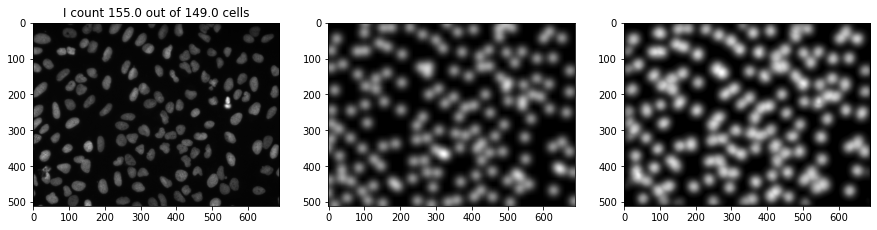

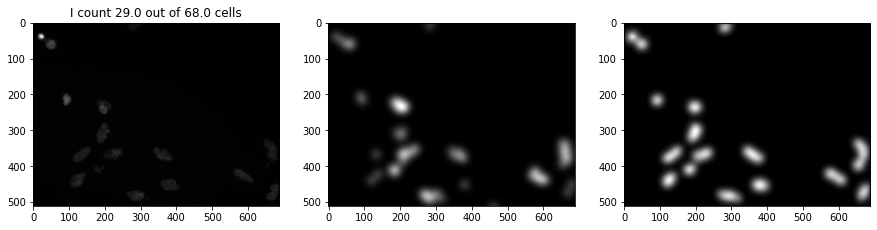

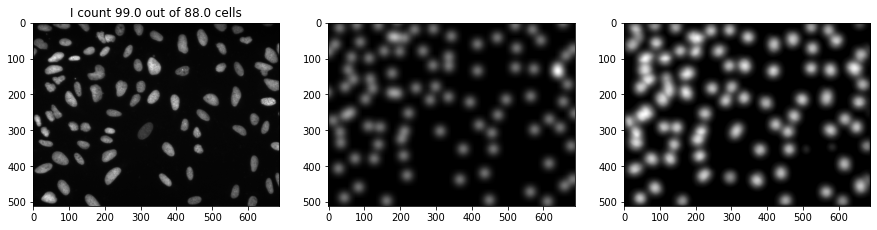

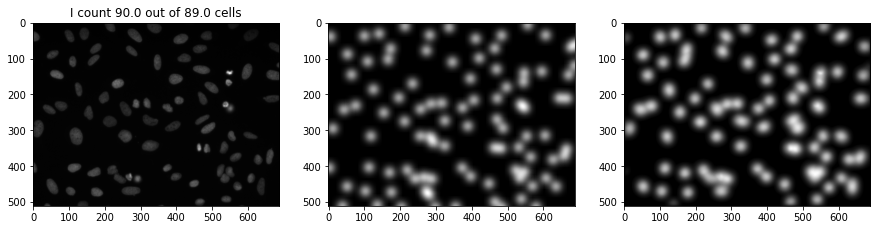

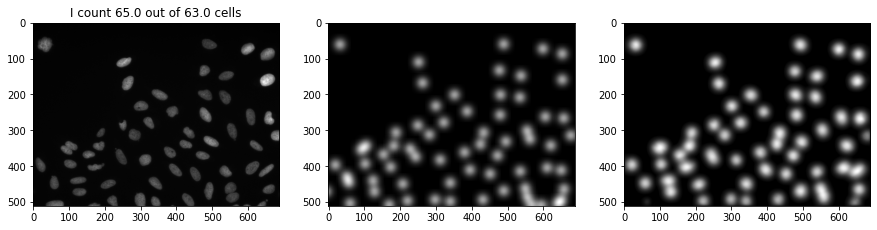

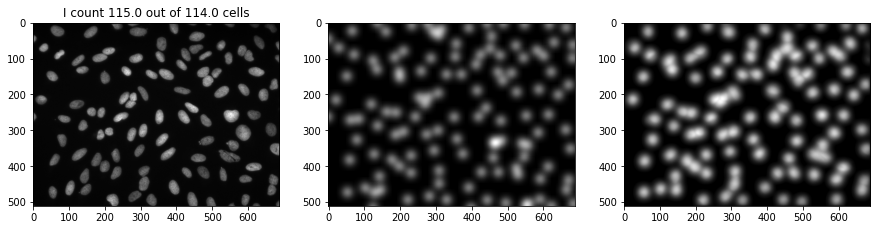

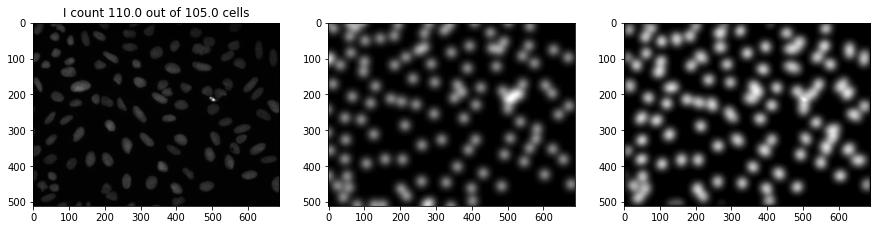

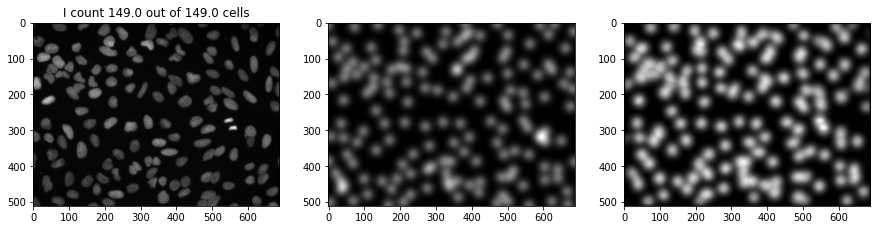

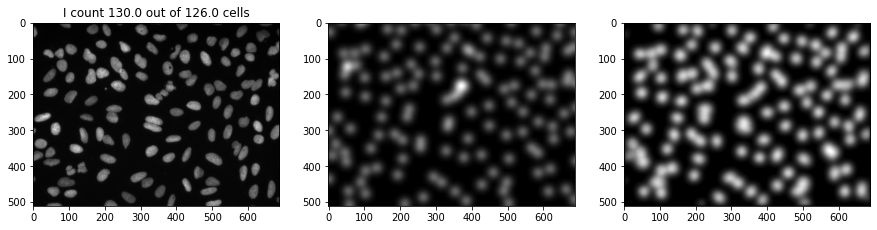

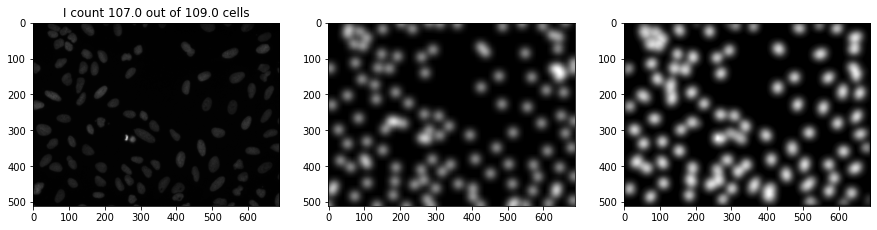

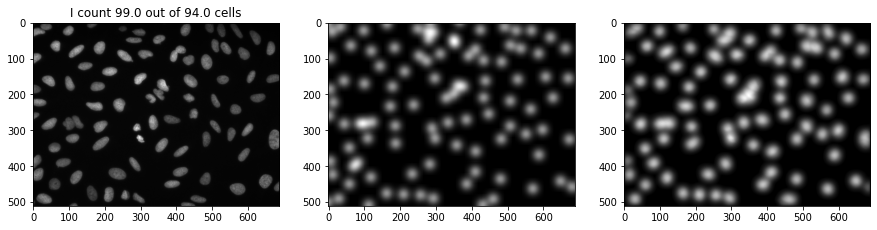

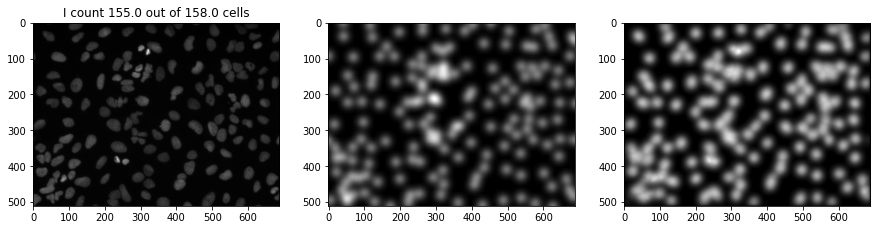

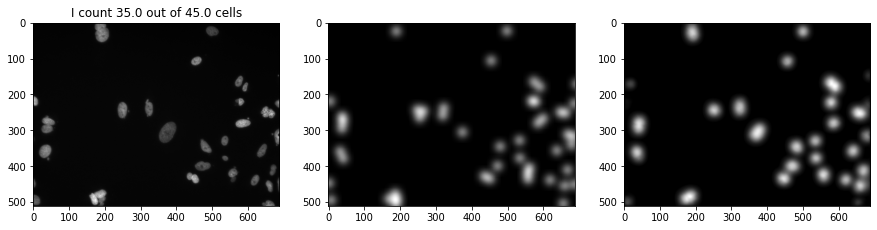

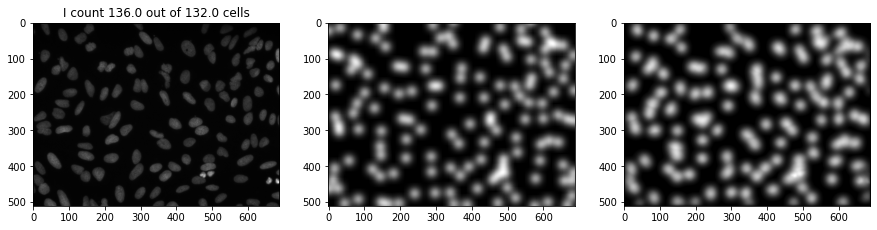

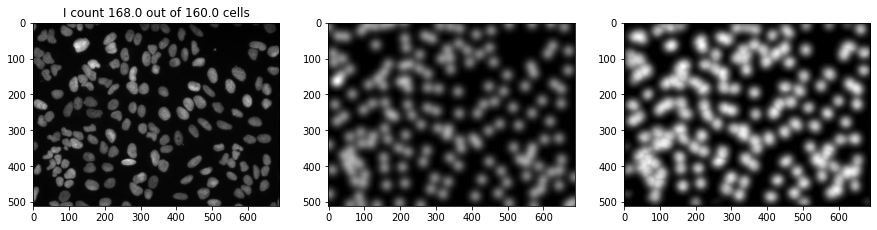

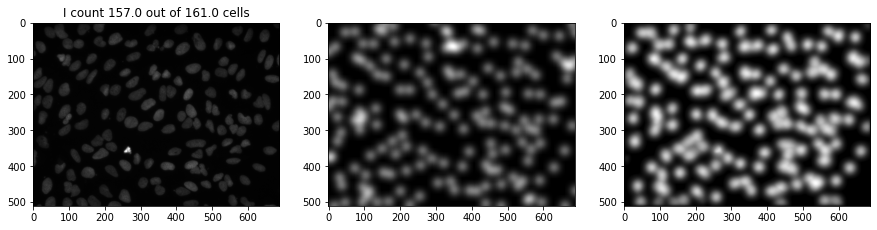

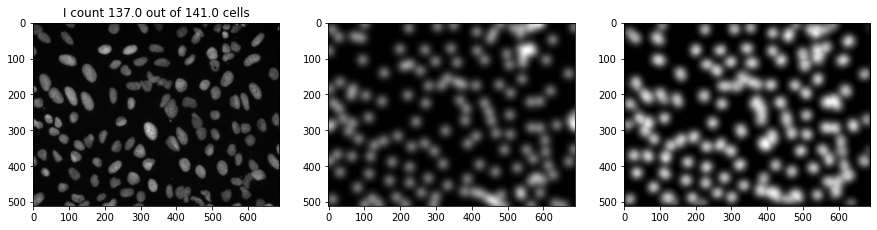

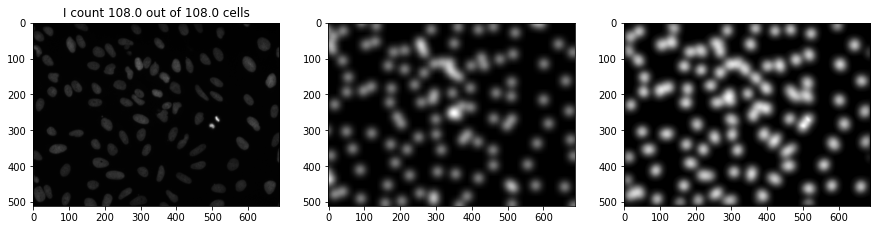

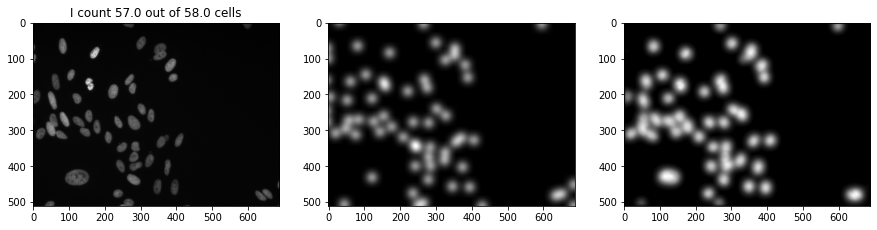

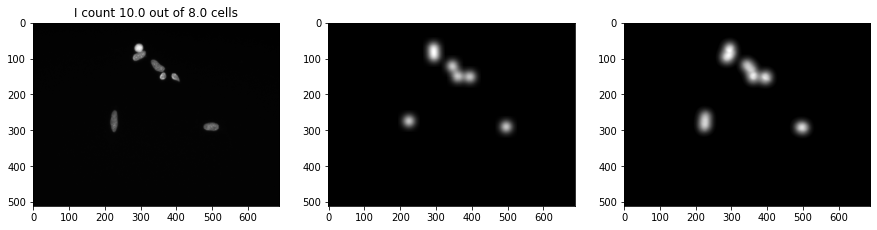

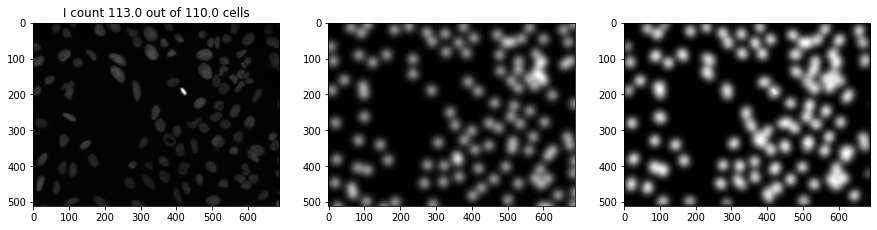

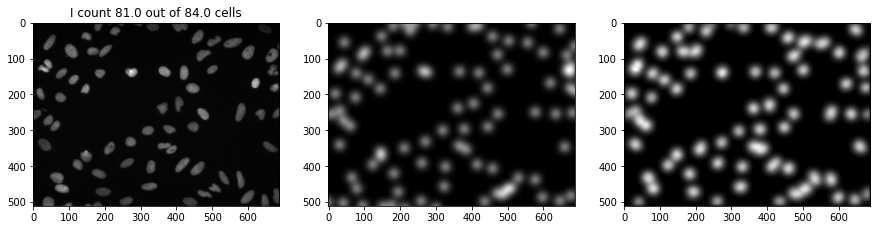

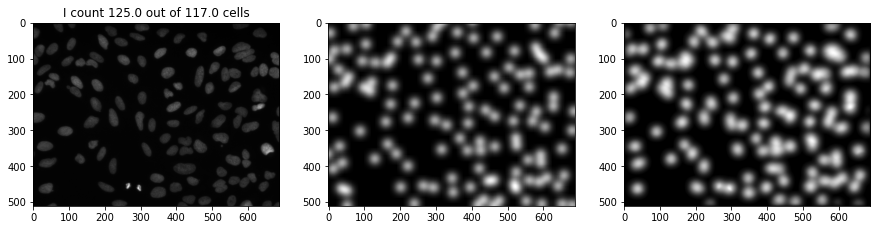

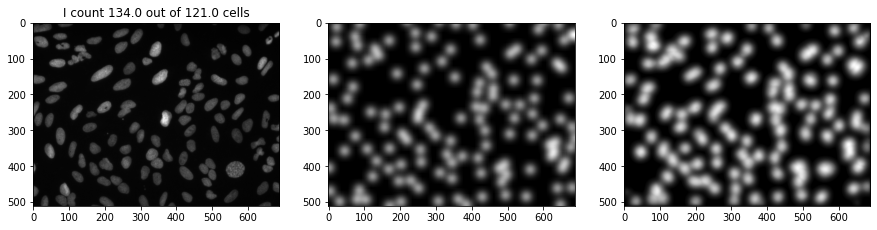

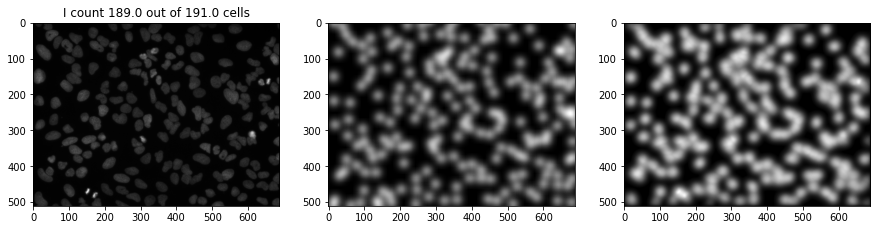

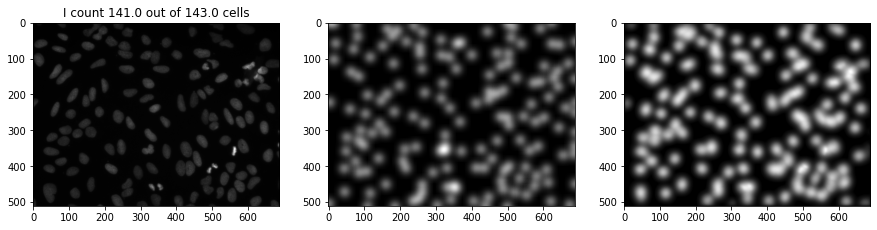

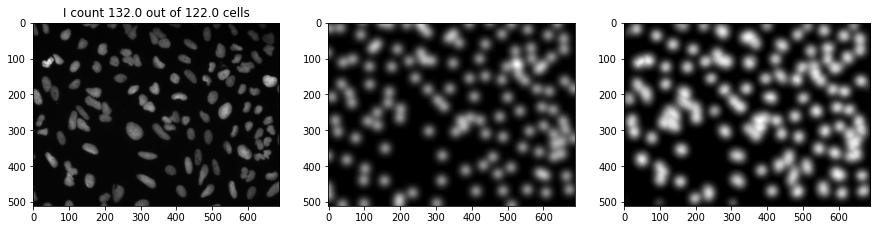

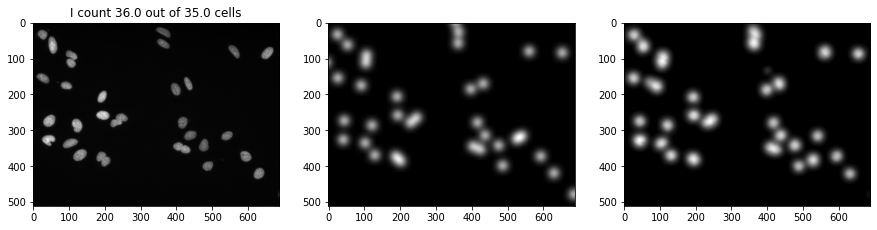

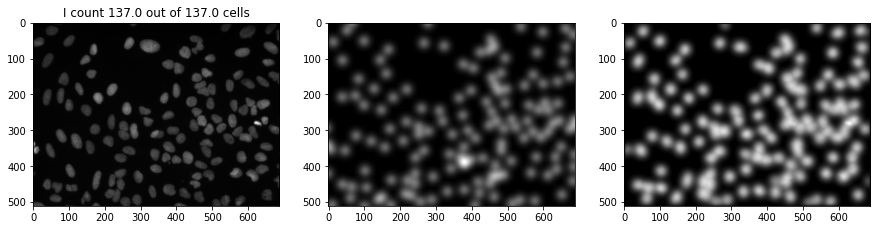

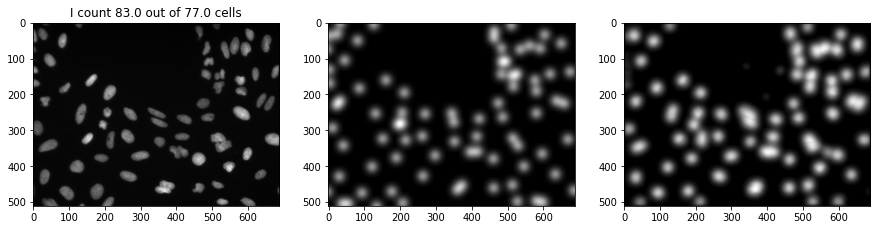

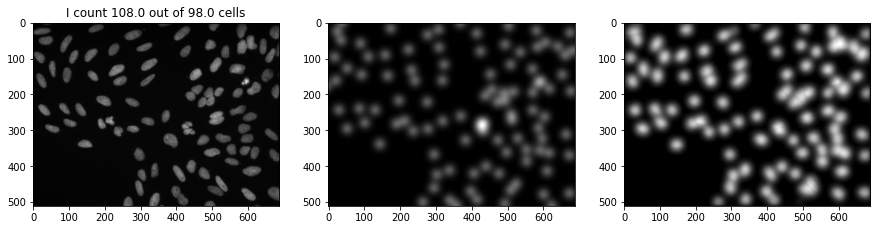

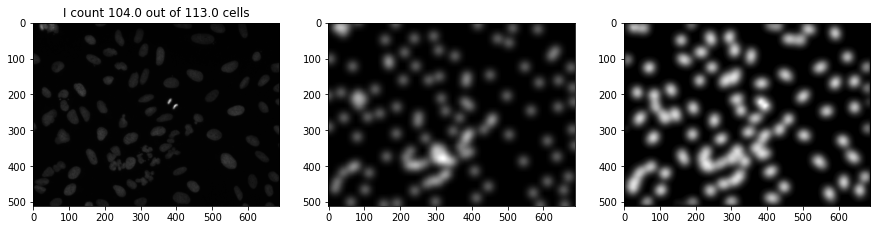

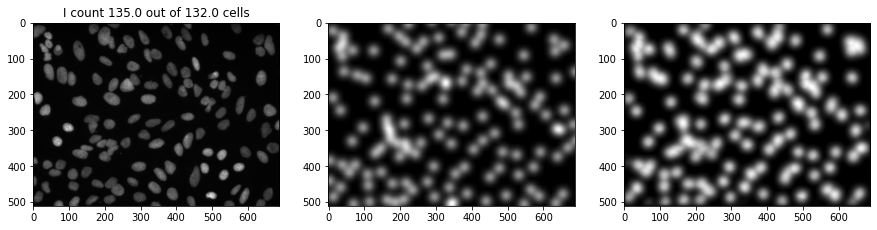

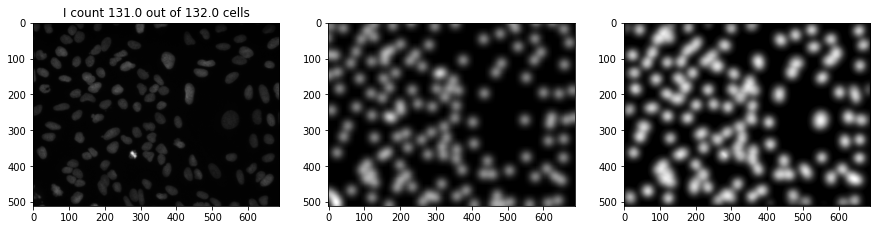

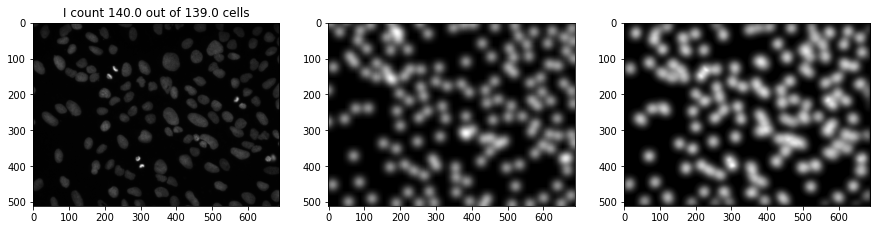

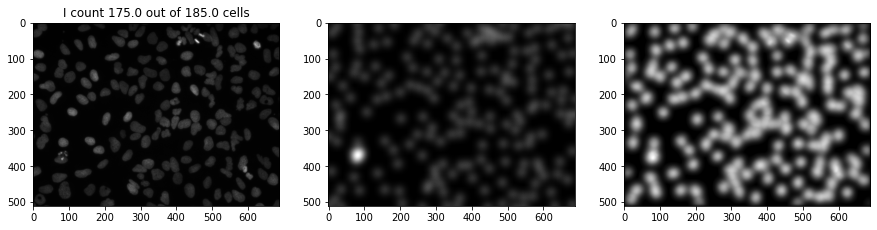

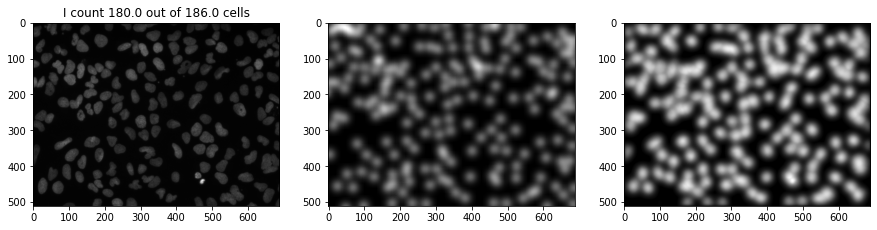

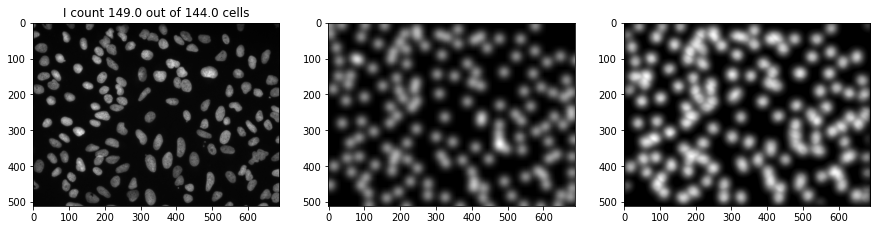

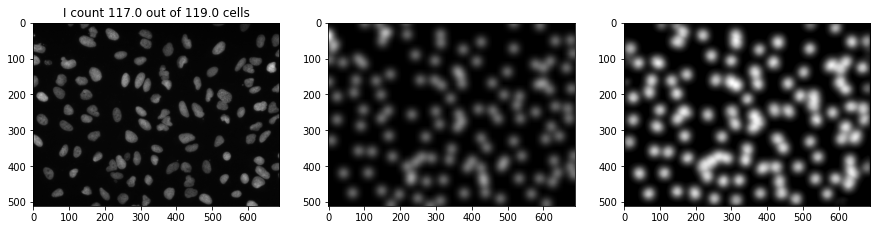

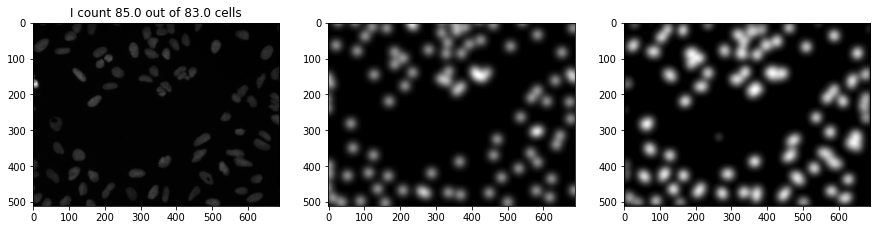

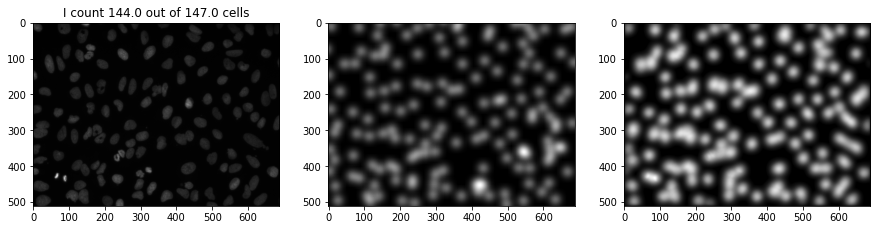

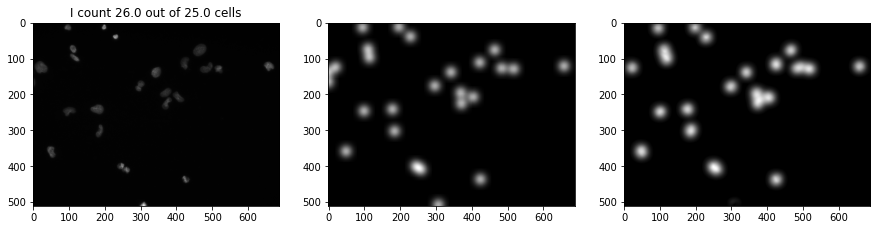

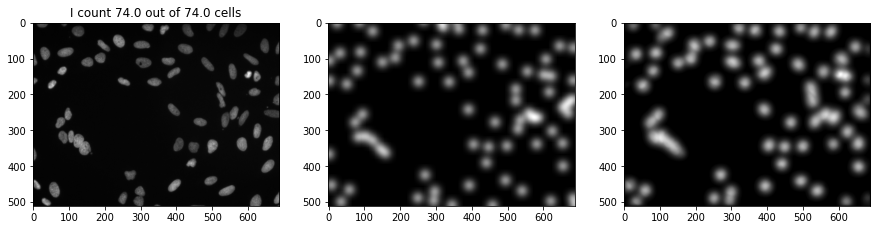

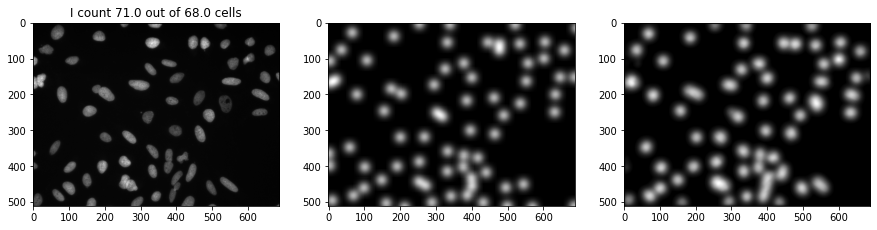

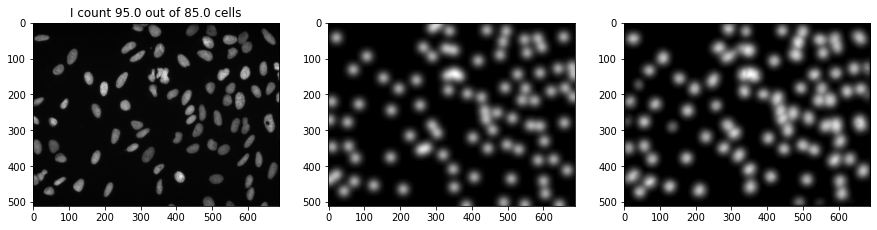

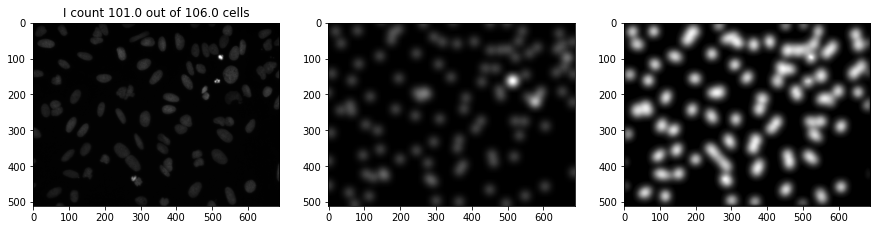

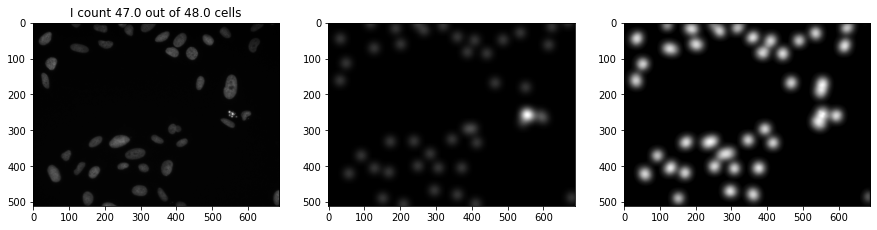

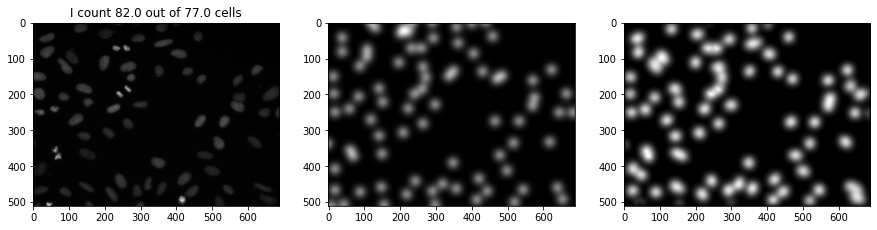

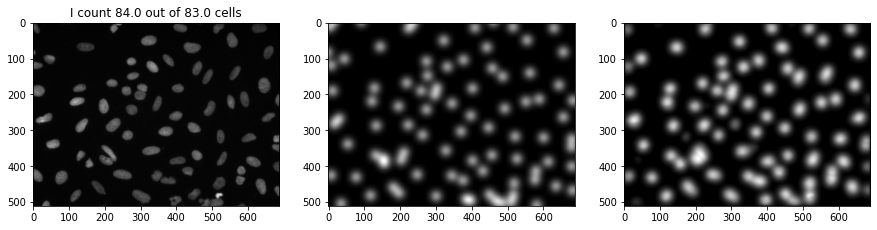

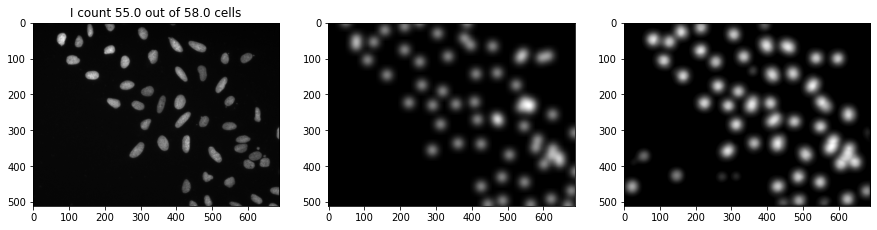

In [20]:
test_set = [test_dataset.update().resolve() for _ in range(len(test_paths))]
test_data = [get_image(v_tuple) for v_tuple in test_set]
test_labels = [get_label(v_tuple) for v_tuple in test_set]

predictions = model.predict(np.array(test_data))
for image, mask, prediction in zip(test_data, test_labels, predictions):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.title("I count {0} out of {1} cells".format(
        np.ceil(np.sum(prediction[:, :, 0]) / NORM_FACTOR),
        np.ceil(np.sum(mask[:, :, 0]) / NORM_FACTOR)
    ))
    
    plt.subplot(132)
    plt.imshow(mask[:, :, 0], cmap="gray")
    
    plt.subplot(133)
    plt.imshow(prediction[:, :, 0], cmap="gray")
    plt.show()
